## CIFAR-10 Adversarial defense using SymDNN - This notebook has limited vizualizations

In [1]:
import torch
import random
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
import faiss
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.dpi'] = 120 
# Basic definitions for CIFAR-10 inference

import sys
sys.path.insert(1, '../core')

In [3]:
batch_size = 1
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Change the dataset folder to the proper location in a new system
testset_cifar = torchvision.datasets.CIFAR10(root='../../../dataset', train=False, download=True, transform=transform_test)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=batch_size, shuffle=False)
testloader_std_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=64, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [4]:
from modeldefs import *

# Base model for Cifar-10 (data [0,1]) 
pretrained_base_clampled_gradinit = './cifar10_resnet_gradinit_sc_232.pt'
model_base_clamped_gradinit = resnet20()
model_base_clamped_gradinit.load_state_dict(torch.load(pretrained_base_clampled_gradinit))
model_base_clamped_gradinit.eval()

ResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

In [5]:
# Define a custom function that will clamp the images between 0 & 1 , without being too harsh as torch.clamp 
def softclamp01(image_tensor):
    image_tensor_shape = image_tensor.shape
    image_tensor = image_tensor.view(image_tensor.size(0), -1)
    image_tensor -= image_tensor.min(1, keepdim=True)[0]
    image_tensor /= image_tensor.max(1, keepdim=True)[0]
    image_tensor = image_tensor.view(image_tensor_shape)
    return image_tensor

In [4]:
# Lets check the kind of prediction the model is doing - the standard non symbolic infrence
def cifar_test_base_acc(model):
    base_clampled_gradinit_clean = 0
    total = 0
    # Clean base gradinit inference   
    for images, labels in testloader_std_cifar:
        with torch.no_grad():
            X = softclamp01(images) 
            y = labels
            output = model.forward(X)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    base_clampled_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(base_clampled_gradinit_clean / total) 

In [45]:
print(" ******++++++++++++++============= Clean base gradinit (scaled data [0,1]) model inference ================+++++++++++******")
acc = cifar_test_base_acc(model_base_clamped_gradinit)
print("Base Non symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Clean base gradinit (scaled data [0,1]) model inference ================+++++++++++******
Base Non symbolic Grad init ((scaled data [0,1]) ) model Accuracy:91.57


In [13]:
# Lets check the kind of prediction the model is doing - the symbolic infrence
def cifar_test_sym_acc(model, n_clusters, index, centroid_lut, patch_size, stride, channel_count):
    sym_clampled_gradinit_clean = 0
    total = 0
    # Sym base gradinit inference   
    for images, labels in testloader_cifar:
        with torch.no_grad():
            X = softclamp01(images) 
            y = labels
            Xsym = symdnn_purify(X, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            output = model.forward(Xsym)
            for idx, i in enumerate(output):
                if torch.argmax(i) == y[idx]:
                    sym_clampled_gradinit_clean += 1
                #else:
                #    # Whenever there is an error, print the image
                #    print("Misclassification: Model: clean base gradinit. Test Image #: {}, Mispredicted label: {}".format(total+1, torch.argmax(i)))
                total +=1
    return float(sym_clampled_gradinit_clean / total)

In [7]:
import faiss
from patchutils import symdnn_purify, fm_to_symbolic_fm
patch_size = (2, 2)
channel_count = 3
stride = 0

In [8]:
index = faiss.read_index("./kmeans_img_k2_s0_c2048_v1_softclamp.index")
n_clusters=2048

In [9]:
centroid_lut = index.reconstruct_n(0, n_clusters)

In [14]:
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 2048) ================+++++++++++******")
acc = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 2048) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:89.42999999999999


In [41]:
# index = faiss.read_index("./kmeans_img_k2_s0_c512_v1_softclamp.index")
# n_clusters=512

In [13]:
centroid_lut = index.reconstruct_n(0, n_clusters)
print(" ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 2048) ================+++++++++++******")
acc = cifar_test_sym_acc(model_base_clamped_gradinit, n_clusters, index, centroid_lut , patch_size, stride, channel_count)
print("Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:{}".format(100 * acc)) 

 ******++++++++++++++============= Symbolic base gradinit (scaled data [0,1]) model inference (cymbols / clusters: 2048) ================+++++++++++******
Symbolic Grad init ((scaled data [0,1]) ) model Accuracy:87.62


In [9]:
import torchvision.utils
from torchvision import models
import torchattacks
from torchattacks import *

print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.1+cpu
Torchvision 0.10.1+cpu
Torchattacks 3.2.0
Numpy 1.19.5


In [10]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
        
        
        
        
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

In [28]:
 def plot_all(img, ttl, norm=False):
    # create figure (fig), and array of axes (ax)
    fig = plt.figure(figsize=(6, 2))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        j = i-1
        if norm:
            norm_img = unorm(img[j])
        else:
            norm_img = img[j]
        #npimg = norm_img.numpy()
        npimg = norm_img
        fig.add_subplot(rows, columns, i)
        plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
        # write title for identification
        plt.rcParams.update({'font.size': 8})
        plt.rcParams["font.weight"] = "bold"
        plt.title(ttl[j])
        #axi.set_axis_off()
        plt.axis('off')

    plt.tight_layout(True)
    plt.show()

In [39]:
def viz_adversarial_attack(atk, model,  num_try, sc, norm=False):
    counter = 0
    correct_std = 0
    correct_std_atk = 0
    correct_sym = 0
    correct_sym_atk = 0
    total =0
    plot_count = 250
    for images, labels in testloader_cifar:
        if sc: 
            # Soft clamp image to make the attack effective
            images_sc = softclamp01(images)
        else:
            images_sc = images
        if counter > num_try:
            break
        #print("For image #",counter)    
        counter += 1
        img_arr = []
        ttl_arr = []
        outputs_orig = model(images_sc)
        _, pre_orig = torch.max(outputs_orig.data, 1)
        if (pre_orig == labels): # We do further testing if the original model is right
            images_std = images_sc
            title_text = "Orig: "+str(classes[labels])
            if counter % plot_count == 0:
                plot_img = images_std.squeeze()
                plot_img = images.squeeze()
                img_arr.append(plot_img)
                ttl_arr.append(title_text)
            correct_std += (pre_orig == labels).sum()

            
            
            # Symbolic inference
            Xsym = symdnn_purify(images_sc, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            outputs_sym = model.forward(Xsym)
            _, pre_sym = torch.max(outputs_sym.data, 1)
            if (pre_sym == labels):
                correct_sym += (pre_sym == labels).sum()
            if counter % plot_count == 0:    
                plot_img = Xsym.squeeze().data.cpu().numpy().copy()
                img_arr.append(plot_img)
                title_text = "Sym: "+str(classes[pre_sym])
                ttl_arr.append(title_text)

            
            # Attack on vanila inference 
            adv_images = atk(images_sc, labels)
            outputs_std = model(adv_images)
            _, pre_std = torch.max(outputs_std.data, 1)
            if (pre_std == labels):
                correct_std_atk += (pre_std == labels).sum()
            if counter % plot_count == 0:
                plot_img_adv = adv_images.squeeze()
                plot_img = plot_img_adv.data.cpu().numpy().copy()
                img_arr.append(plot_img)
                title_text = "Orig (perturb) :"+str(classes[pre_std])
                ttl_arr.append(title_text)
                
            # Attack on symbolic inference 
            pfm = adv_images.data.cpu().numpy().copy()
            # Re-classify the perturbed image
            Xsym = symdnn_purify(pfm, n_clusters, index, centroid_lut, patch_size, stride, channel_count)
            outputs_sym_atk = model.forward(Xsym)
            _, pre_sym_atk = torch.max(outputs_sym_atk.data, 1)
            if (pre_sym_atk == labels):
                correct_sym_atk += (pre_sym_atk == labels).sum()
            if counter % plot_count == 0:
                plot_img = Xsym.squeeze().data.cpu().numpy().copy()
                img_arr.append(plot_img)
                title_text = "Sym (perturb):"+str(classes[pre_sym_atk])
                ttl_arr.append(title_text)
            
            if counter % plot_count == 0:
                plot_all(img_arr, ttl_arr, norm) 
        total += 1
            
    print('Attack on model: {}'.format(atk))
    print('Standard accuracy: %.2f %%' % (100 * float(correct_std) / total))
    print('Symbolic accuracy: %.2f %%' % (100 * float(correct_sym) / total))
    print('Attacked standard accuracy: %.2f %%' % (100 * float(correct_std_atk) / total))
    print('Attacked Symbolic accuracy: %.2f %%' % (100 * float(correct_sym_atk) / total))    

In [19]:
import torchattacks
from torchattacks import *
print("PyTorch", torch.__version__)
print("Torchvision", torchvision.__version__)
print("Torchattacks", torchattacks.__version__)
print("Numpy", np.__version__)

PyTorch 1.9.1+cpu
Torchvision 0.10.1+cpu
Torchattacks 3.2.0
Numpy 1.19.5


In [20]:
atks = [
    FGSM(model_base_clamped_gradinit, eps=8/255),
    BIM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100),
    RFGSM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100),
    CW(model_base_clamped_gradinit, c=1, lr=0.01, steps=100, kappa=0),
    PGD(model_base_clamped_gradinit, eps=8/255, alpha=2/225, steps=100, random_start=True),
    PGDL2(model_base_clamped_gradinit, eps=1, alpha=0.2, steps=100),
    EOTPGD(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100, eot_iter=2),
    FFGSM(model_base_clamped_gradinit, eps=8/255, alpha=10/255),
    TPGD(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100),
    MIFGSM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100, decay=0.1),
    VANILA(model_base_clamped_gradinit),
    GN(model_base_clamped_gradinit, sigma=0.1),
    APGD(model_base_clamped_gradinit, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='ce'),
    APGD(model_base_clamped_gradinit, eps=8/255, steps=100, eot_iter=1, n_restarts=1, loss='dlr'),
    APGDT(model_base_clamped_gradinit, eps=8/255, steps=100, eot_iter=1, n_restarts=1),
    FAB(model_base_clamped_gradinit, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False),
    FAB(model_base_clamped_gradinit, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True),
    Square(model_base_clamped_gradinit, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'),
    AutoAttack(model_base_clamped_gradinit, eps=8/255, n_classes=10, version='standard'),
    OnePixel(model_base_clamped_gradinit, pixels=5, inf_batch=50),
    DeepFool(model_base_clamped_gradinit, steps=100),
    DIFGSM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5, resize_rate=0.9)
]

## FAB - L_inf, targeted=False

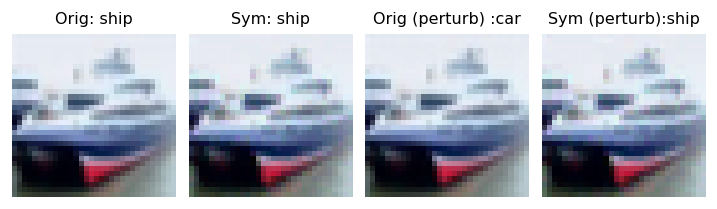

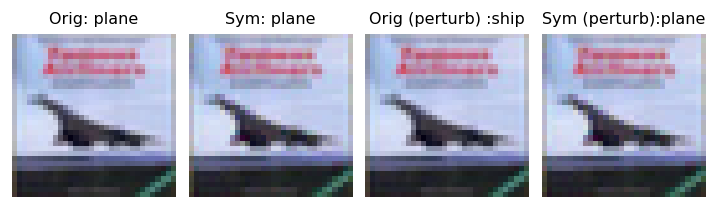

KeyboardInterrupt: 

In [38]:
viz_adversarial_attack(FAB(model_base_clamped_gradinit, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False), model_base_clamped_gradinit, 1000,  True,  norm=False)

## FAB - L_inf, targeted=True

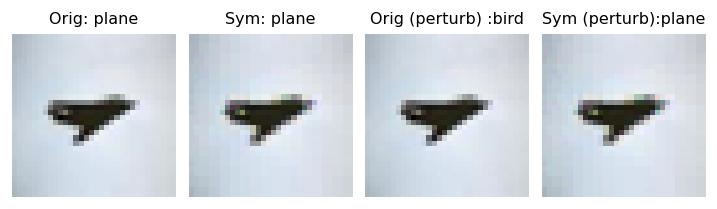

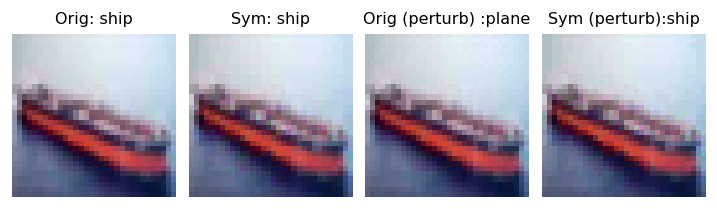

Attack on model: FAB(model_name=ResNet, device=cpu, norm=Linf, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, orig_dim=[3, 32, 32], ndims=3, attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 0.00 %
Attacked Symbolic accuracy: 85.91 %


In [23]:
viz_adversarial_attack(FAB(model_base_clamped_gradinit, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=True), model_base_clamped_gradinit, 1000,  True,  norm=False)

## FAB - L_2

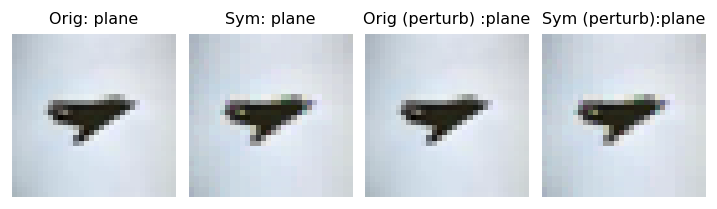

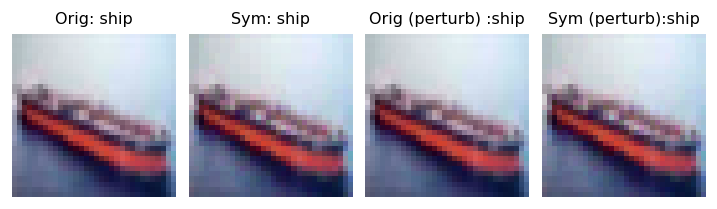

Attack on model: FAB(model_name=ResNet, device=cpu, norm=L2, n_restarts=1, eps=0.03137254901960784, alpha_max=0.1, eta=1.05, beta=0.9, steps=100, targeted=False, verbose=False, seed=0, target_class=None, n_target_classes=9, orig_dim=[3, 32, 32], ndims=3, attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 78.22 %
Attacked Symbolic accuracy: 87.51 %


In [21]:
viz_adversarial_attack(FAB(model_base_clamped_gradinit, eps=8/255, steps=100, n_classes=10, n_restarts=1, targeted=False, norm='L2'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## CW - L_inf

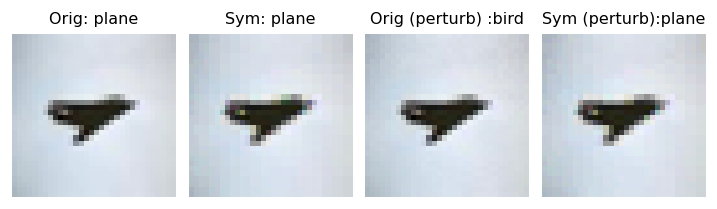

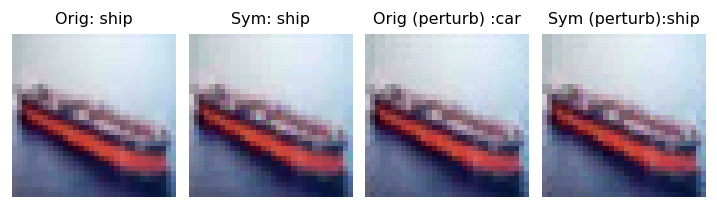

Attack on model: CW(model_name=ResNet, device=cpu, c=1, kappa=0, steps=100, lr=0.01, attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 0.00 %
Attacked Symbolic accuracy: 64.24 %


In [16]:
viz_adversarial_attack(CW(model_base_clamped_gradinit, c=1, lr=0.01, steps=100, kappa=0), model_base_clamped_gradinit, 1000,  True,  norm=False)

## Square - L_inf

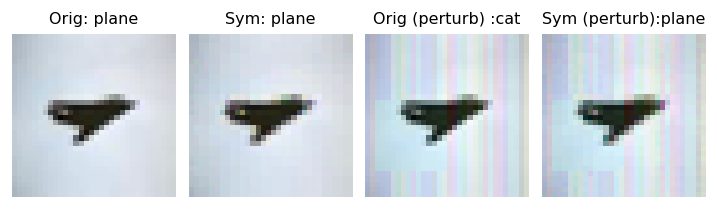

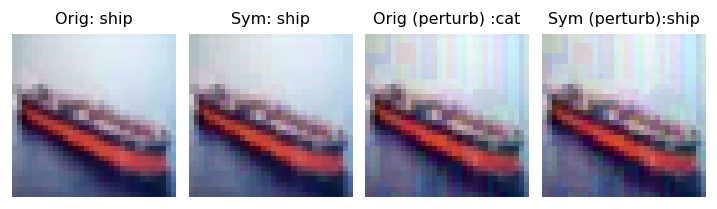

Attack on model: Square(model_name=ResNet, device=cpu, norm=Linf, n_queries=5000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, orig_dim=[3, 32, 32], ndims=3, attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 12.99 %
Attacked Symbolic accuracy: 60.94 %


In [30]:
viz_adversarial_attack(Square(model_base_clamped_gradinit, eps=8/255, n_queries=5000, n_restarts=1, loss='ce'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## SQUARE - L_2

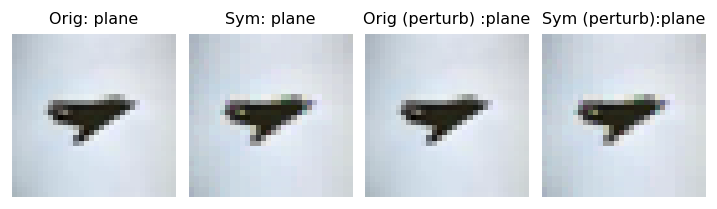

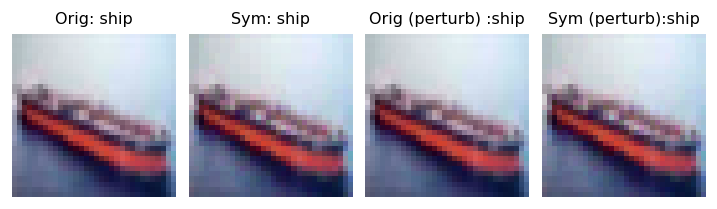

Attack on model: Square(model_name=ResNet, device=cpu, norm=L2, n_queries=5000, eps=0.03137254901960784, p_init=0.8, n_restarts=1, seed=0, verbose=False, loss=ce, rescale_schedule=True, orig_dim=[3, 32, 32], ndims=3, attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 87.41 %
Attacked Symbolic accuracy: 88.11 %


In [46]:
viz_adversarial_attack(Square(model_base_clamped_gradinit, eps=8/255, n_queries=5000, n_restarts=1, loss='ce', norm='L2'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## AutoAttack -L_inf

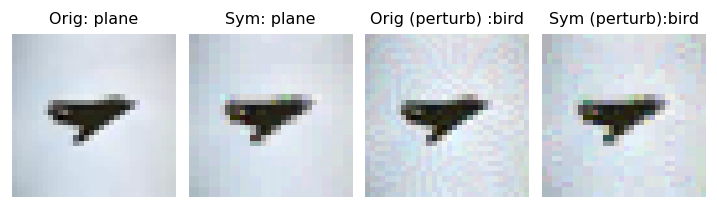

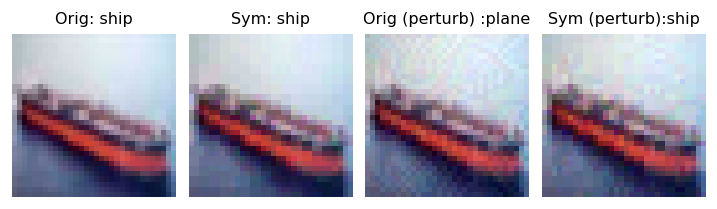

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=Linf, eps=0.03137254901960784, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7fcf59109970>, <torchattacks.attacks.apgdt.APGDT object at 0x7fcf59109fa0>, <torchattacks.attacks.fab.FAB object at 0x7fcf59109b50>, <torchattacks.attacks.square.Square object at 0x7fcf591097f0>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 79.02 %
Attacked standard accuracy: 0.00 %
Attacked Symbolic accuracy: 13.29 %


In [37]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=8/255, n_classes=10, version='standard'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## AutoAttack -L_2

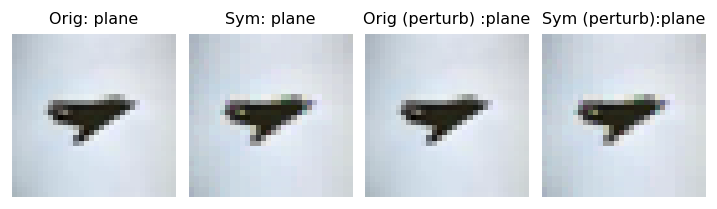

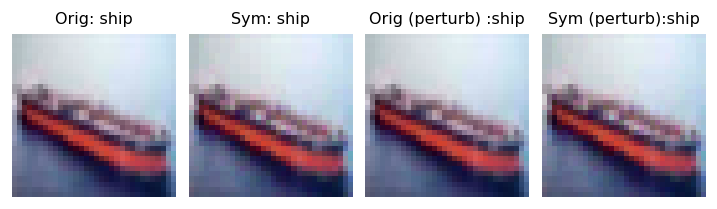

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=L2, eps=0.03137254901960784, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7f71203073a0>, <torchattacks.attacks.apgdt.APGDT object at 0x7f71233282e0>, <torchattacks.attacks.fab.FAB object at 0x7f71202f1370>, <torchattacks.attacks.square.Square object at 0x7f71203074f0>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 77.92 %
Attacked Symbolic accuracy: 86.71 %


In [47]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=8/255, n_classes=10, version='standard', norm='L2'), model_base_clamped_gradinit, 1000,  True,  norm=False)

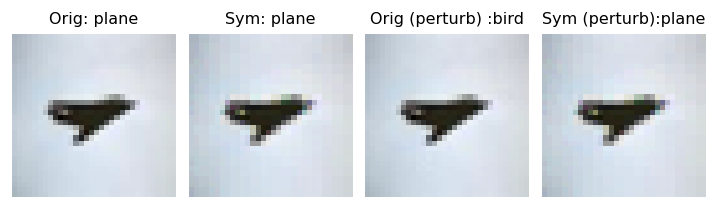

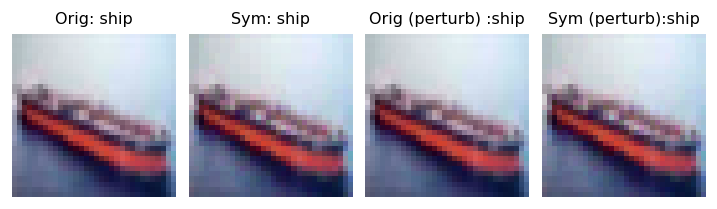

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=L2, eps=0.06274509803921569, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7f711085d940>, <torchattacks.attacks.apgdt.APGDT object at 0x7f711085d970>, <torchattacks.attacks.fab.FAB object at 0x7f711085d9a0>, <torchattacks.attacks.square.Square object at 0x7f711085d9d0>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 55.74 %
Attacked Symbolic accuracy: 82.52 %


In [50]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=16/255, n_classes=10, version='standard', norm='L2'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## AutoAttack - visible patterns at even 8/255

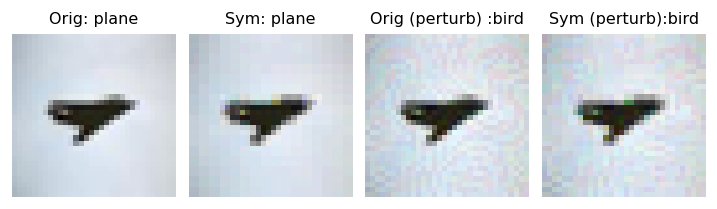

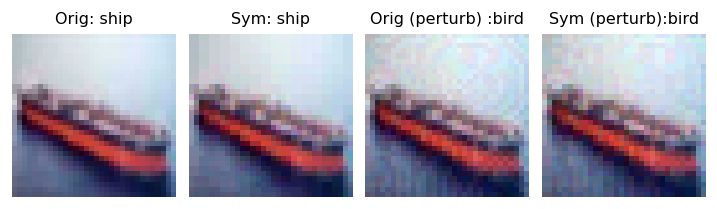

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=Linf, eps=0.03137254901960784, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7fcf5a26aca0>, <torchattacks.attacks.apgdt.APGDT object at 0x7fcf692c47c0>, <torchattacks.attacks.fab.FAB object at 0x7fcf68384d60>, <torchattacks.attacks.square.Square object at 0x7fcf5764cee0>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 83.72 %
Attacked standard accuracy: 0.00 %
Attacked Symbolic accuracy: 2.10 %


In [40]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=8/255, n_classes=10, version='standard'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## AutoAttack - visible patterns at even 4/255

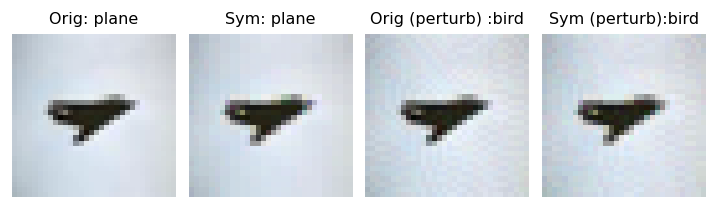

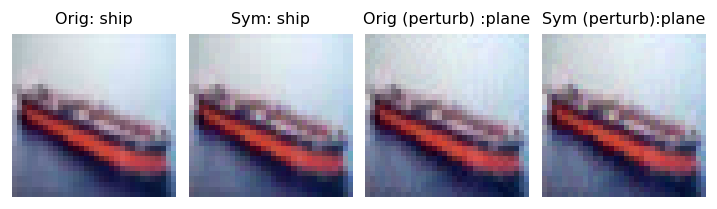

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=Linf, eps=0.01568627450980392, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7fcf591379a0>, <torchattacks.attacks.apgdt.APGDT object at 0x7fcf68356430>, <torchattacks.attacks.fab.FAB object at 0x7fcf682e65b0>, <torchattacks.attacks.square.Square object at 0x7fcf591378e0>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 0.00 %
Attacked Symbolic accuracy: 2.90 %


In [45]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=4/255, n_classes=10, version='standard'), model_base_clamped_gradinit, 1000,  True,  norm=False)

## AutoAttack - visible patterns at even 2/255

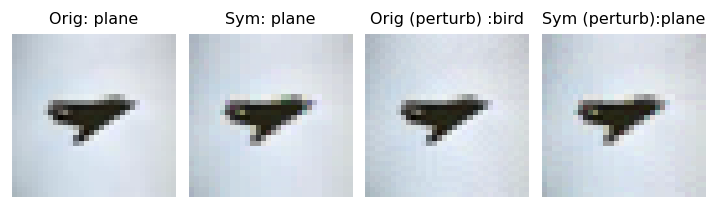

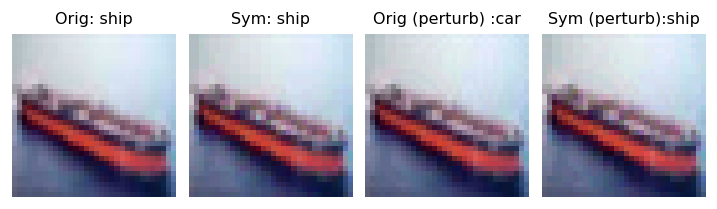

Attack on model: AutoAttack(model_name=ResNet, device=cpu, norm=Linf, eps=0.00784313725490196, version=standard, n_classes=10, seed=None, verbose=False, autoattack=MultiAttack(model_name=ResNet, device=cpu, attacks=[<torchattacks.attacks.apgd.APGD object at 0x7fcf54becaf0>, <torchattacks.attacks.apgdt.APGDT object at 0x7fcf54bec1f0>, <torchattacks.attacks.fab.FAB object at 0x7fcf54becc10>, <torchattacks.attacks.square.Square object at 0x7fcf54becd90>], verbose=False, attack_mode=default, return_type=float), attack_mode=default, return_type=float)
Standard accuracy: 92.31 %
Symbolic accuracy: 88.21 %
Attacked standard accuracy: 0.10 %
Attacked Symbolic accuracy: 35.36 %


In [46]:
viz_adversarial_attack(AutoAttack(model_base_clamped_gradinit, eps=2/255, n_classes=10, version='standard'), model_base_clamped_gradinit, 1000,  True,  norm=False)

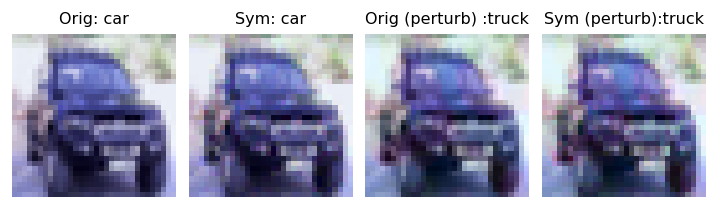

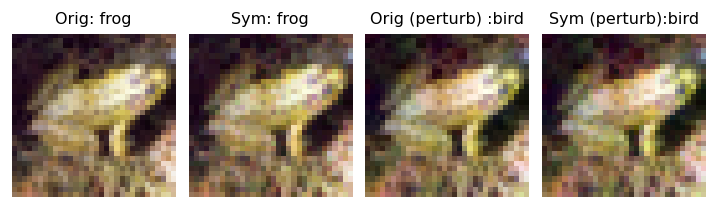

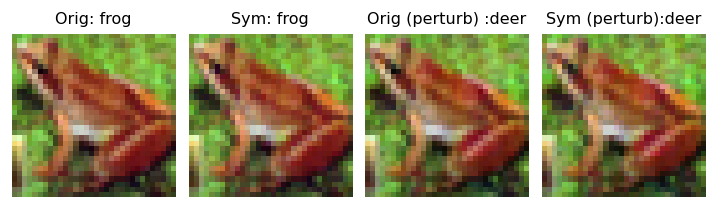

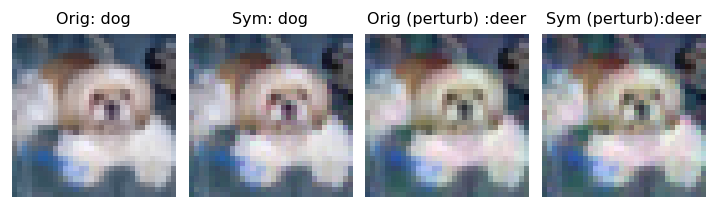

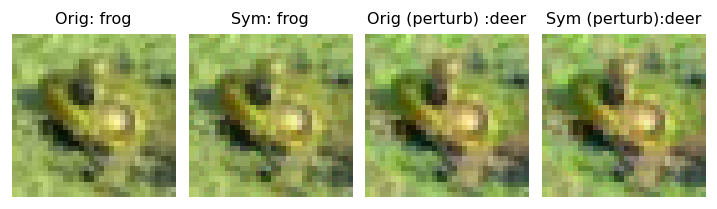

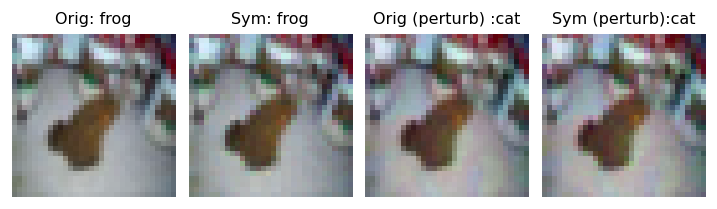

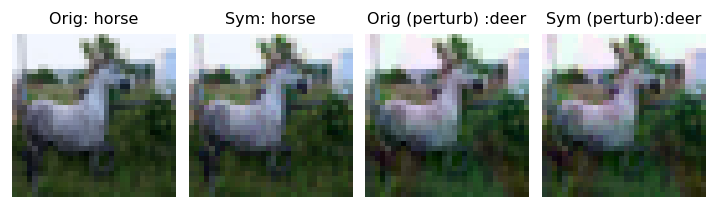

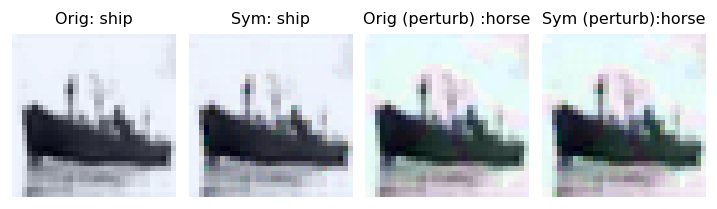

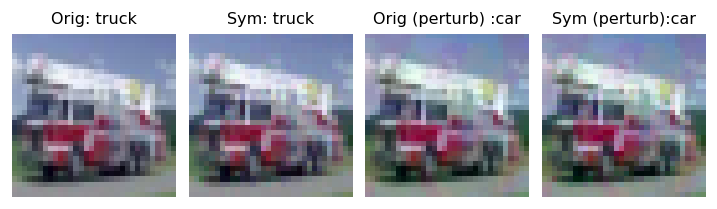

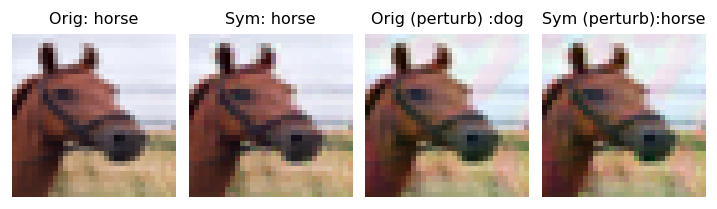

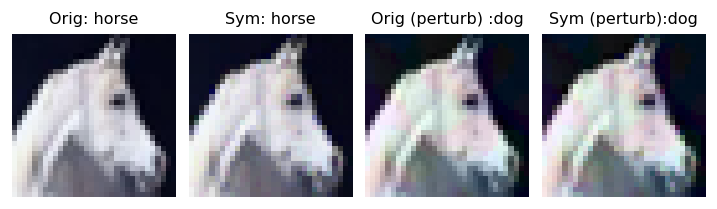

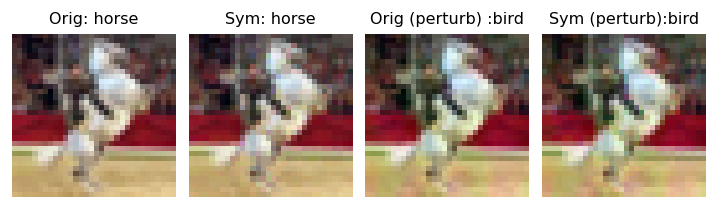

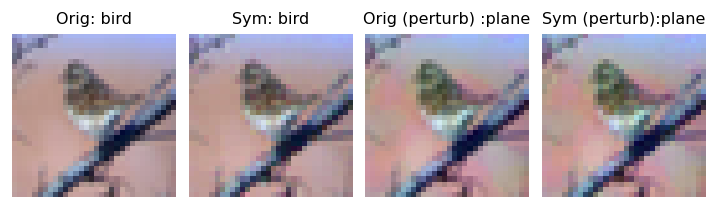

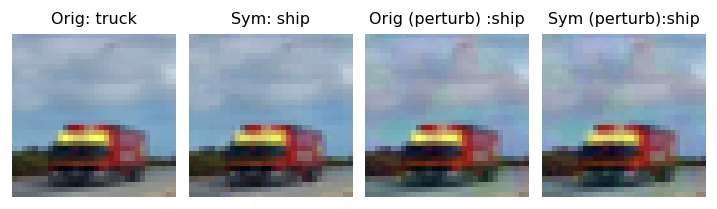

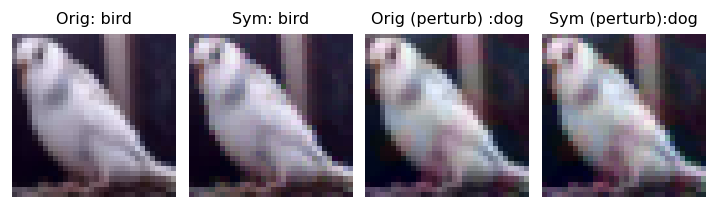

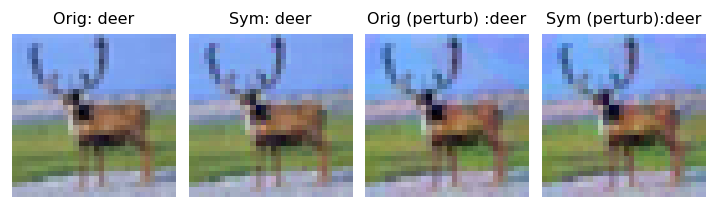

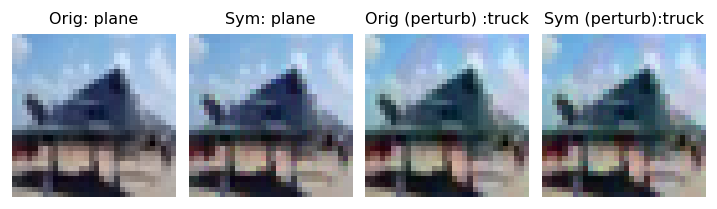

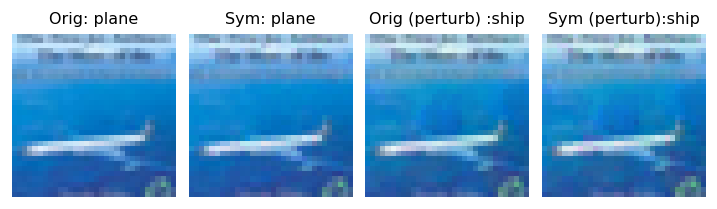

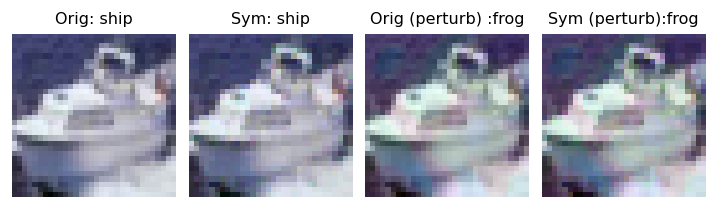

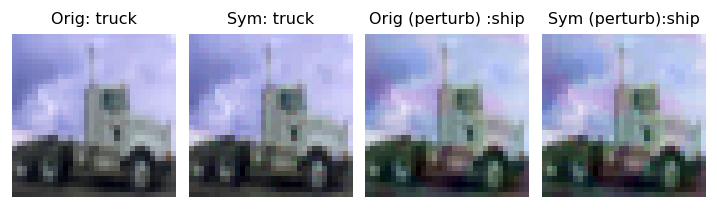

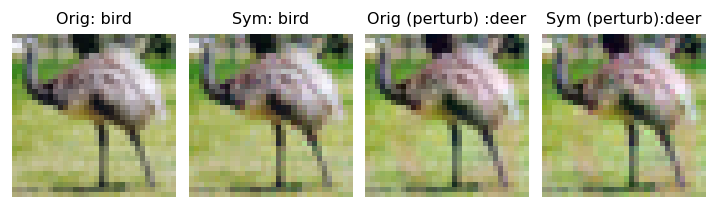

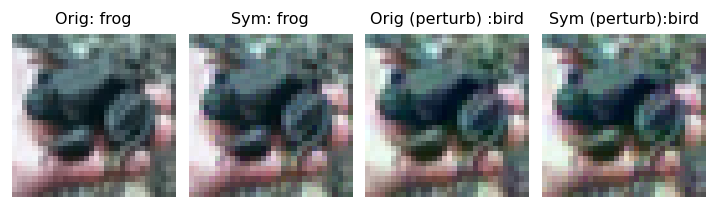

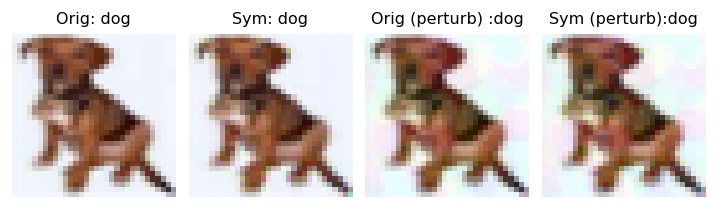

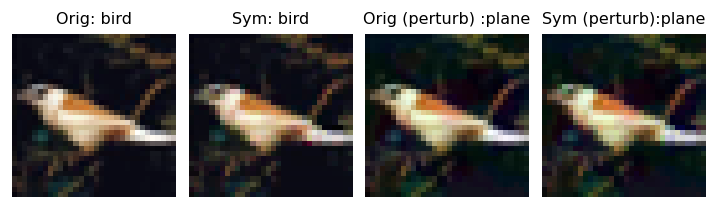

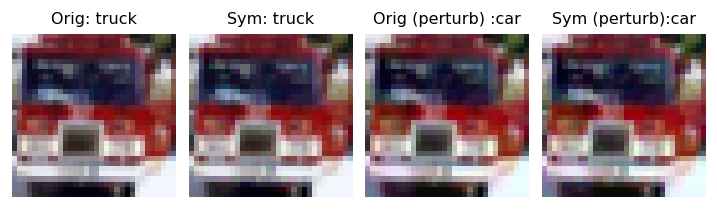

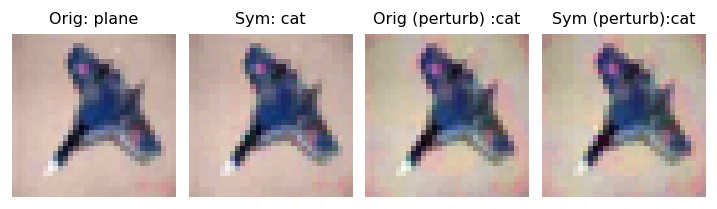

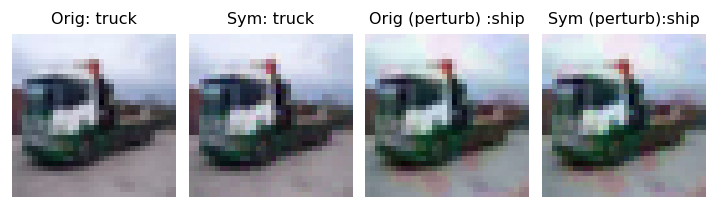

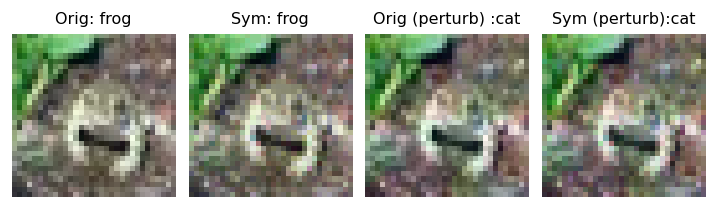

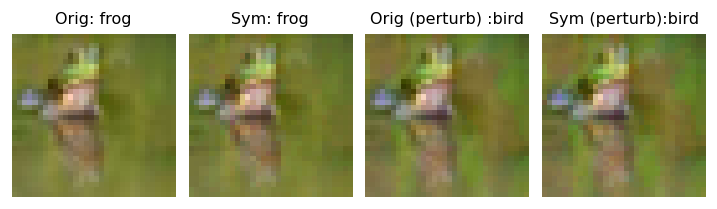

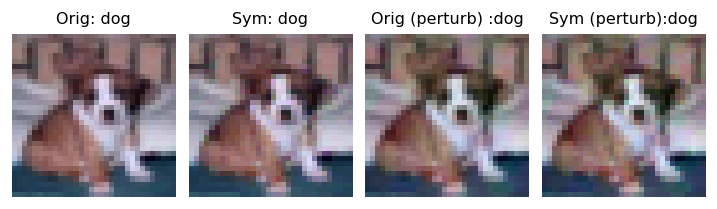

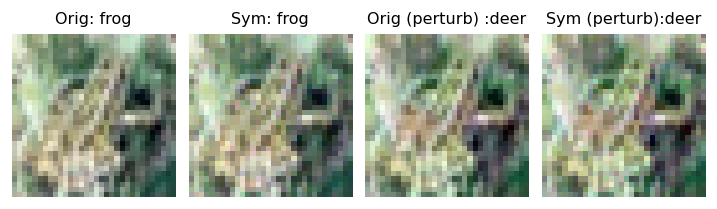

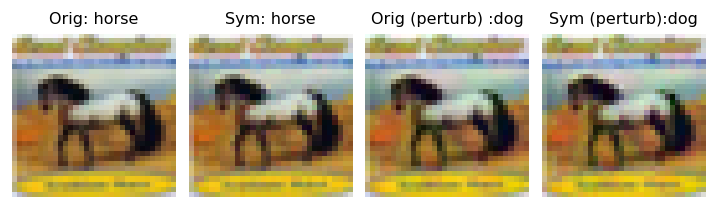

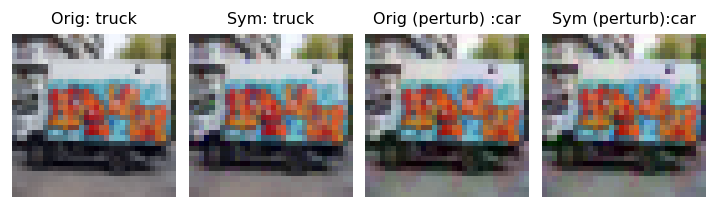

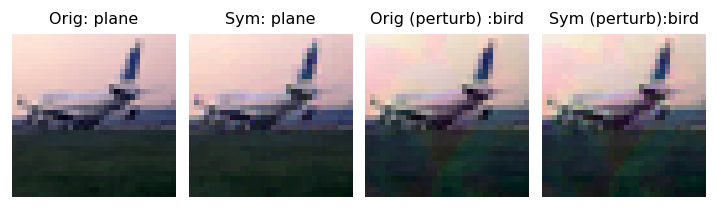

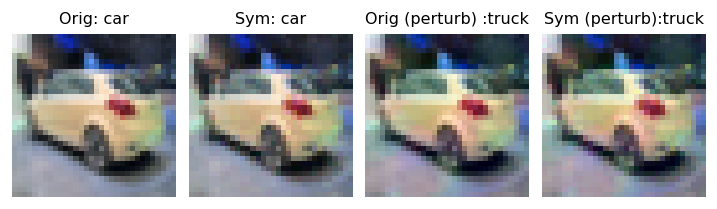

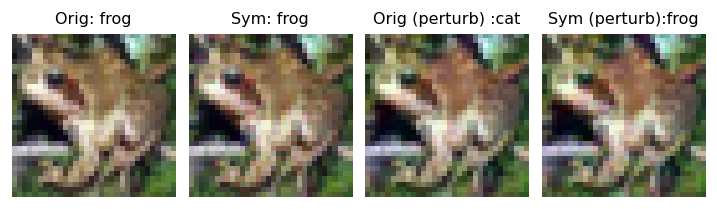

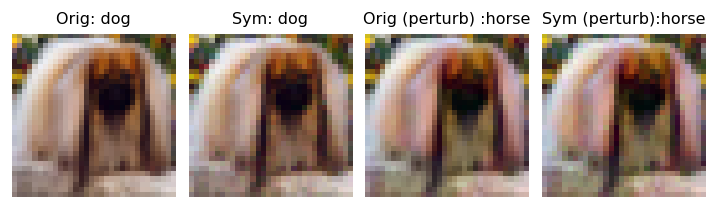

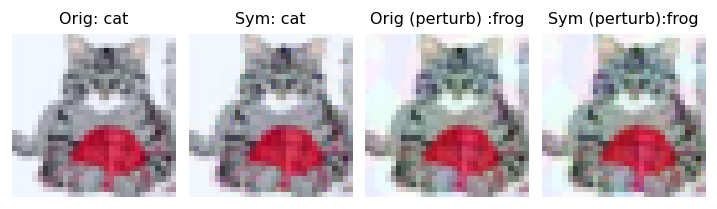

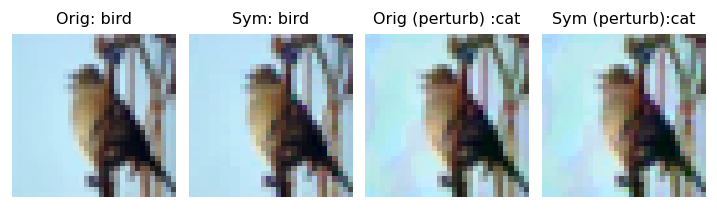

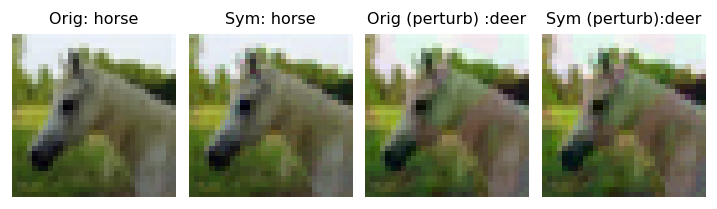

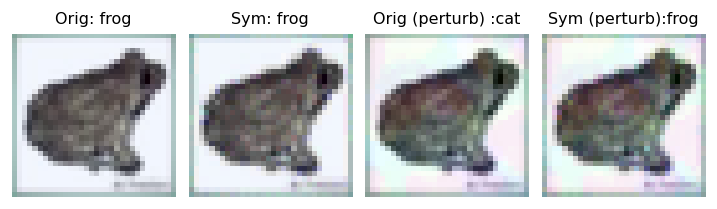

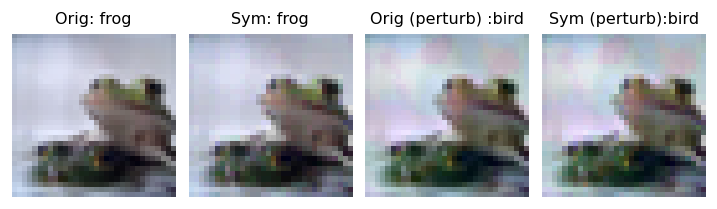

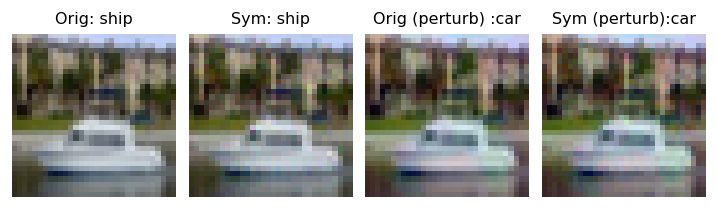

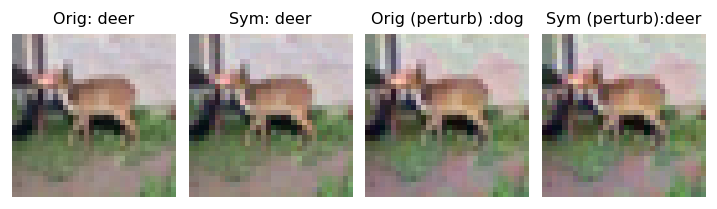

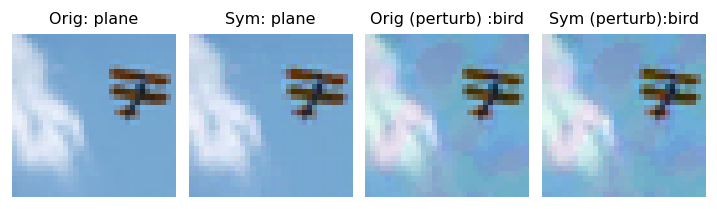

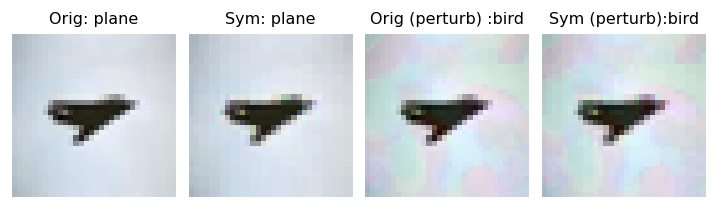

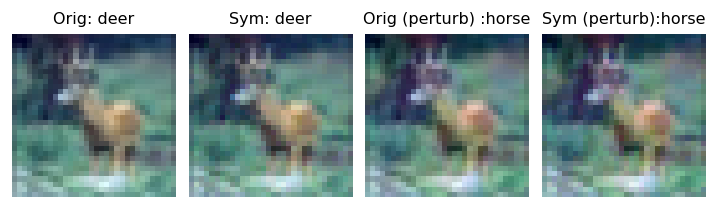

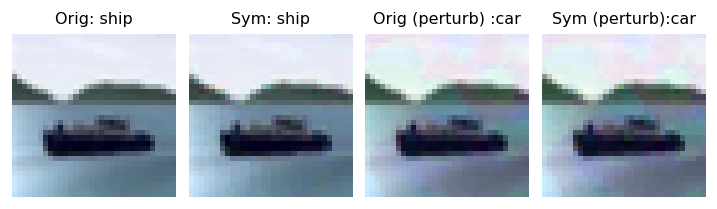

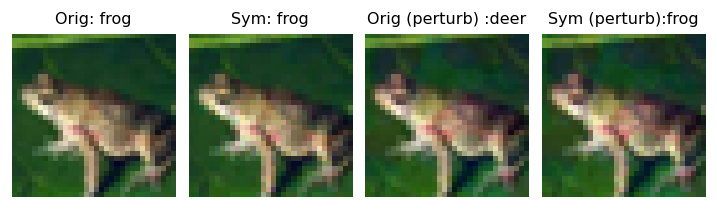

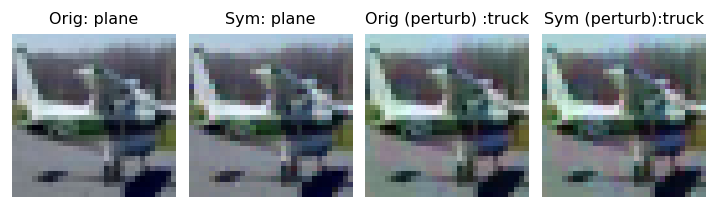

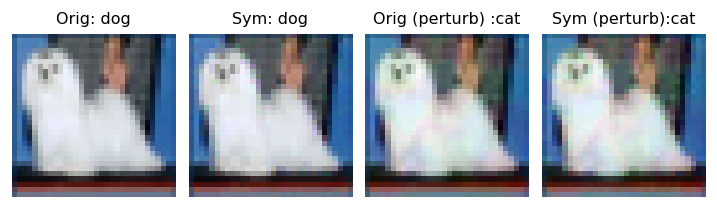

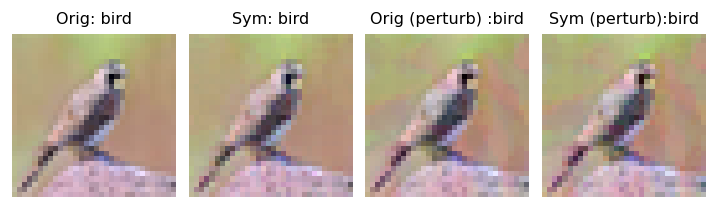

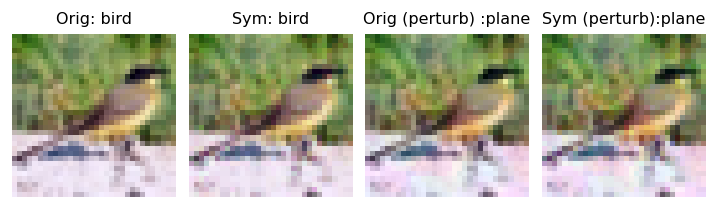

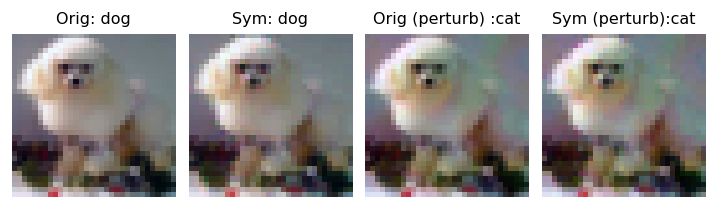

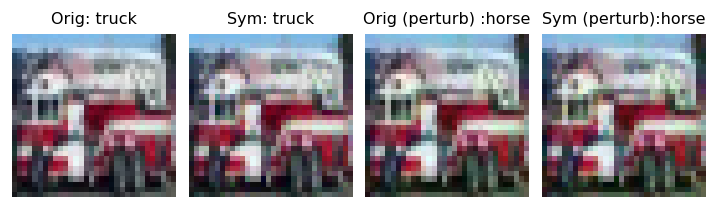

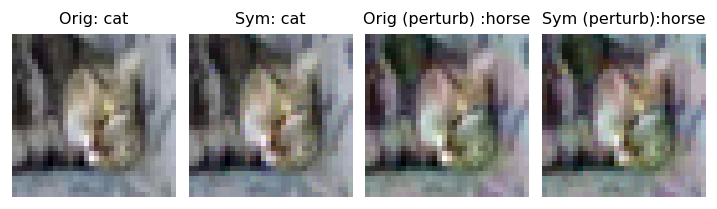

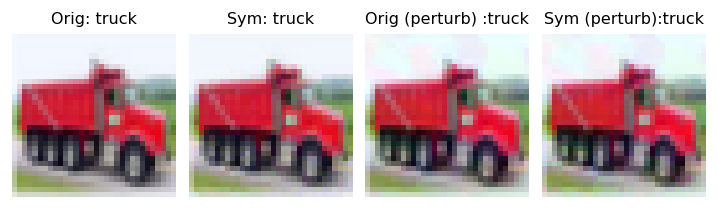

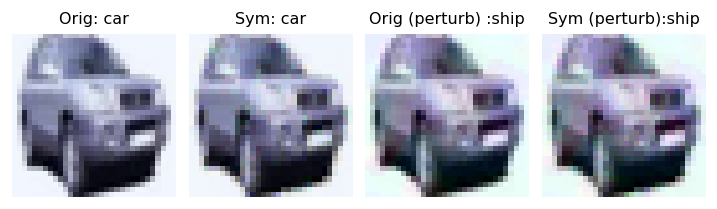

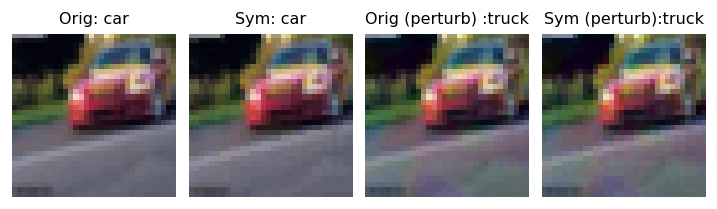

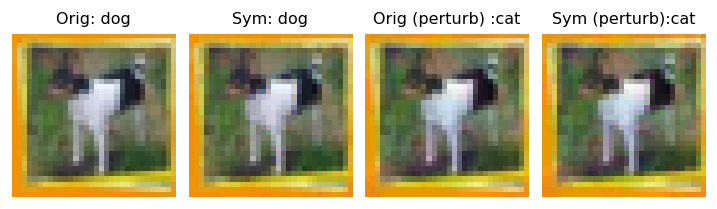

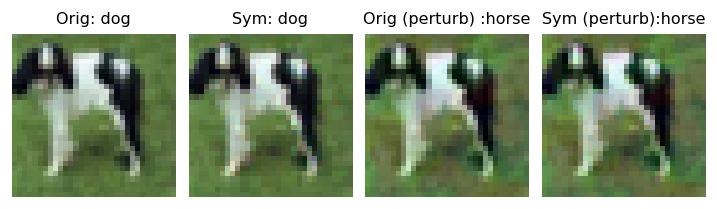

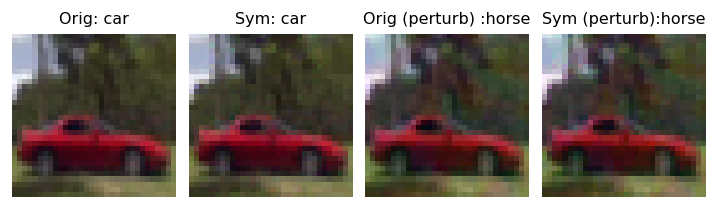

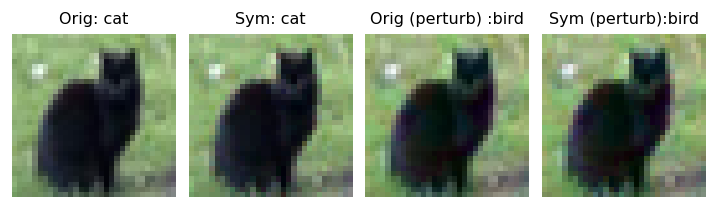

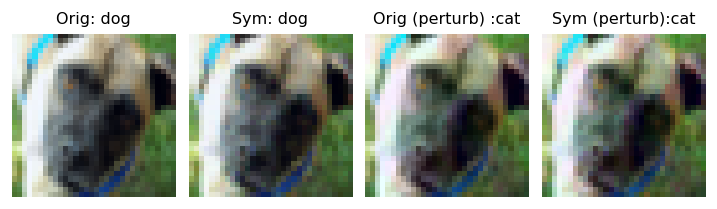

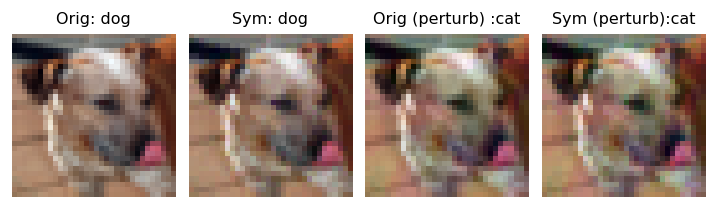

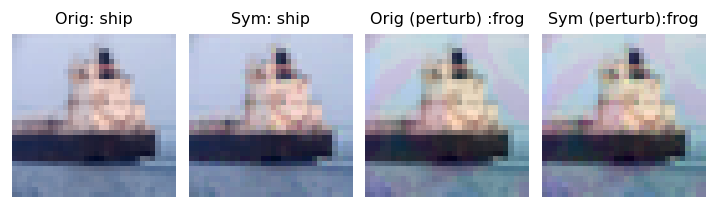

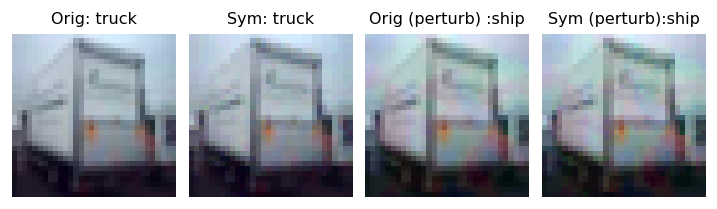

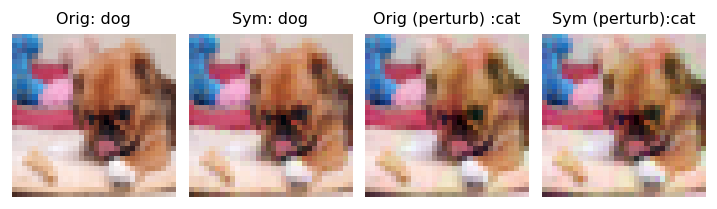

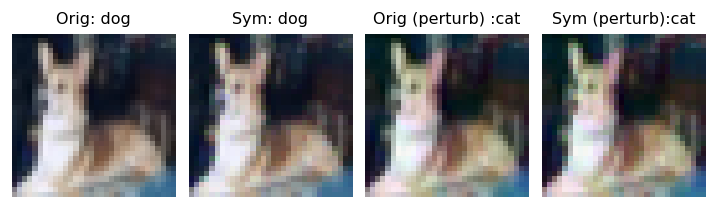

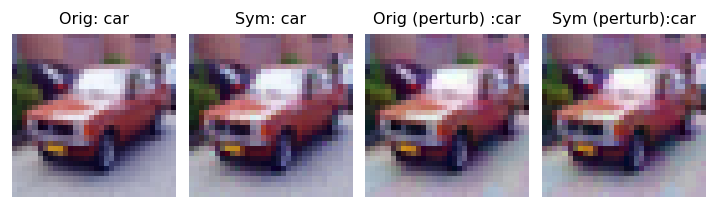

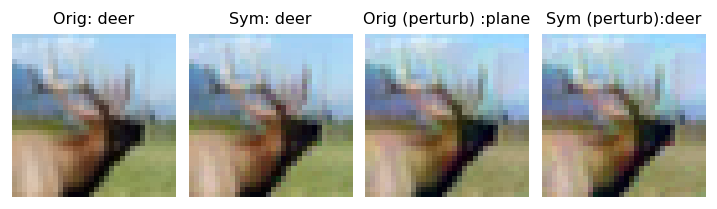

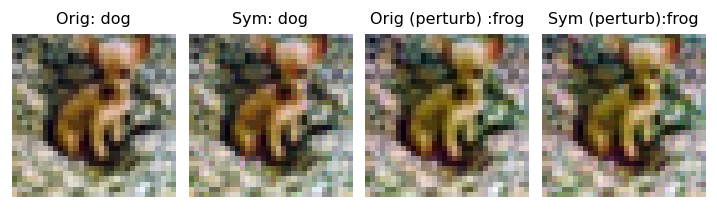

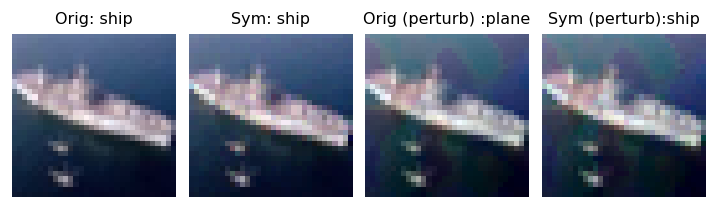

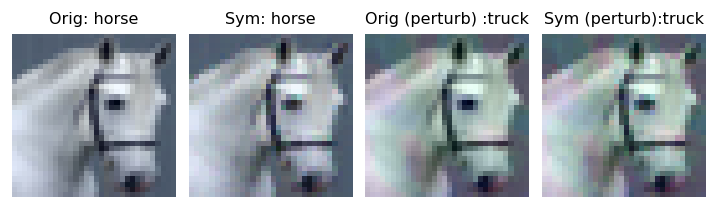

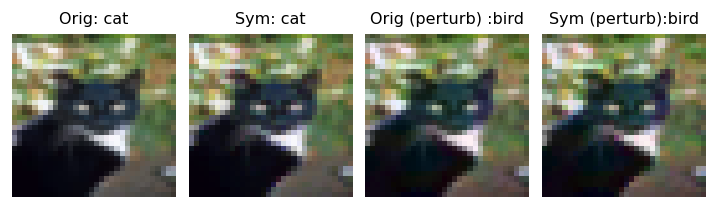

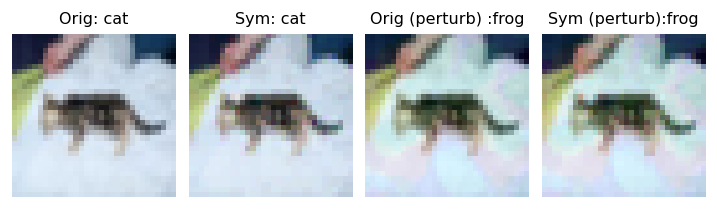

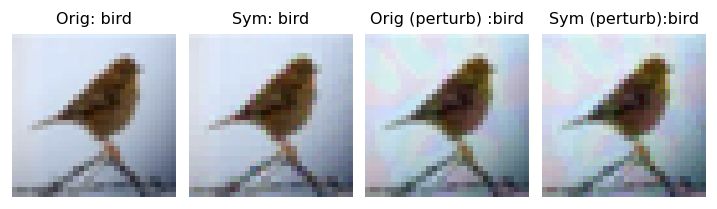

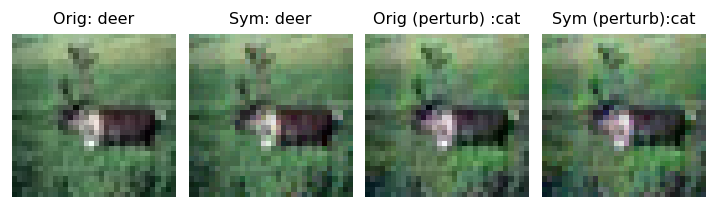

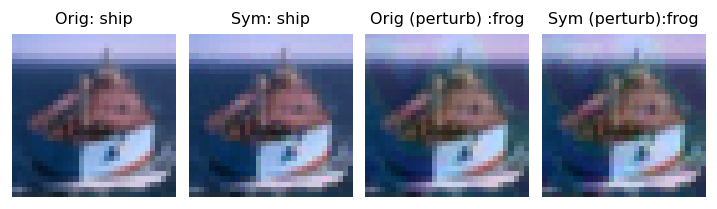

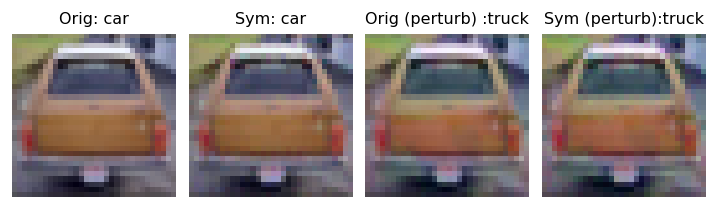

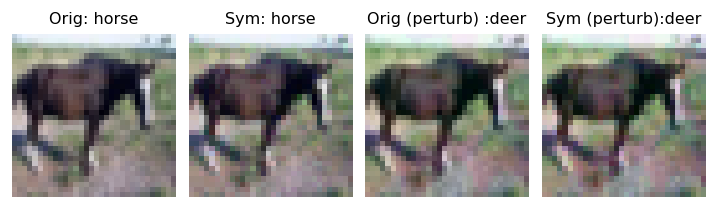

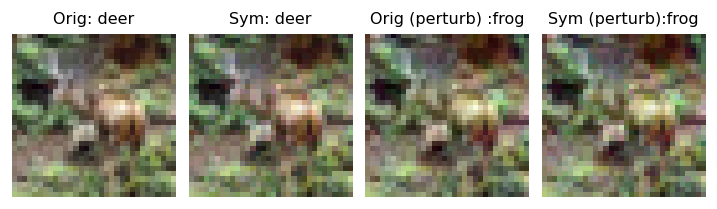

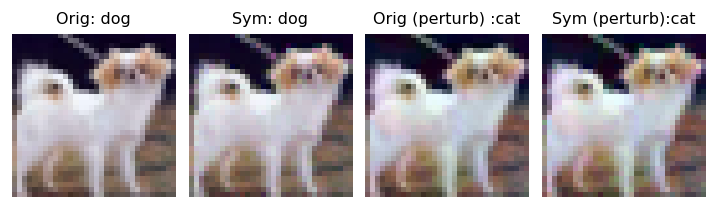

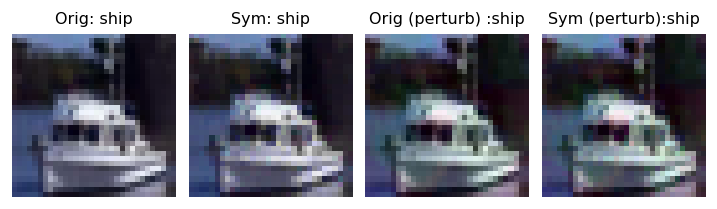

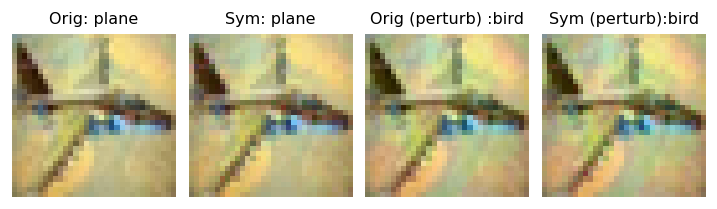

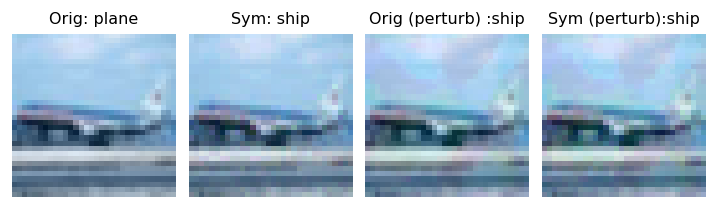

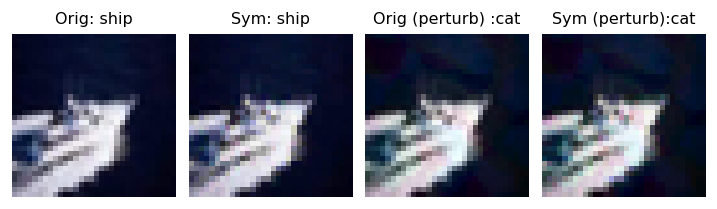

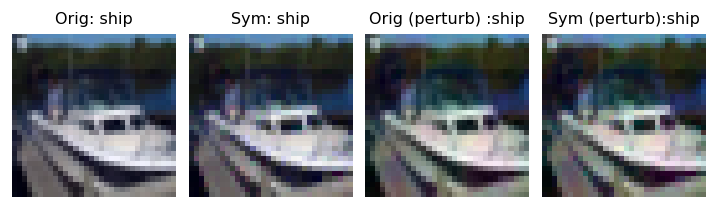

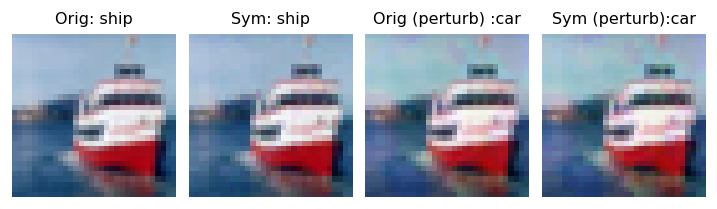

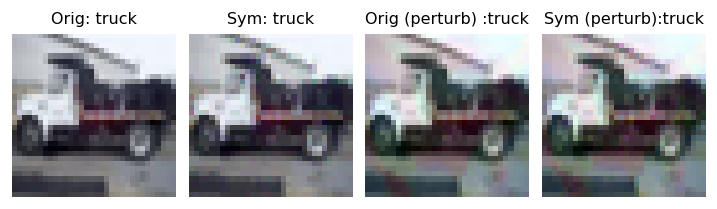

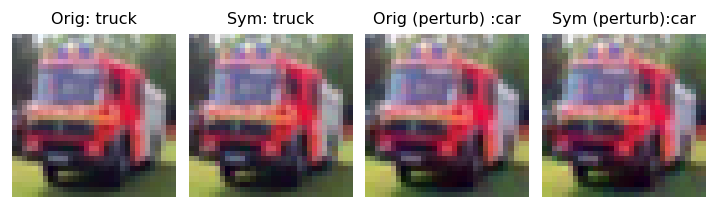

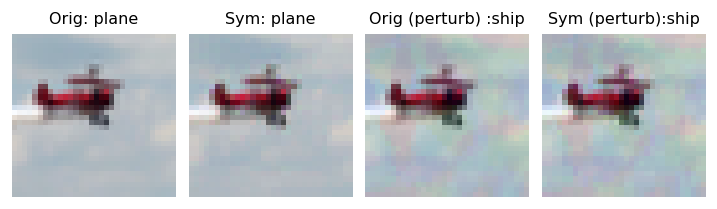

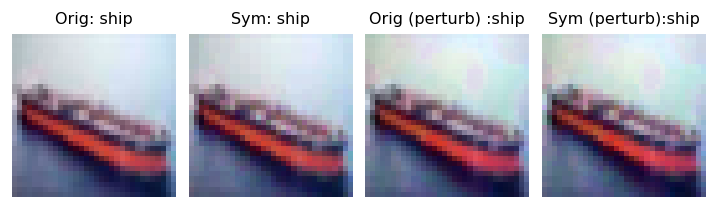

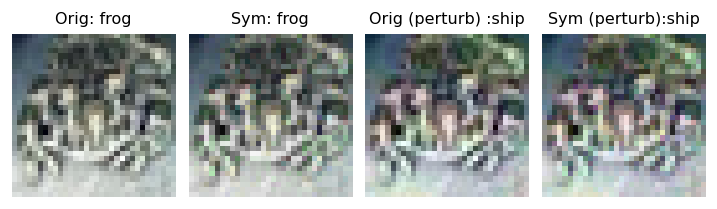

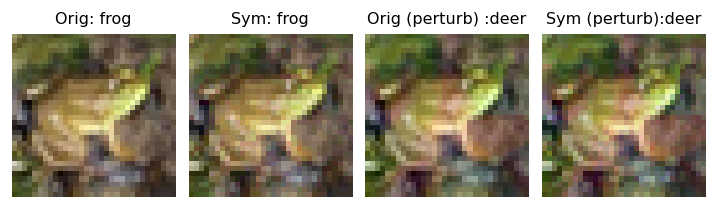

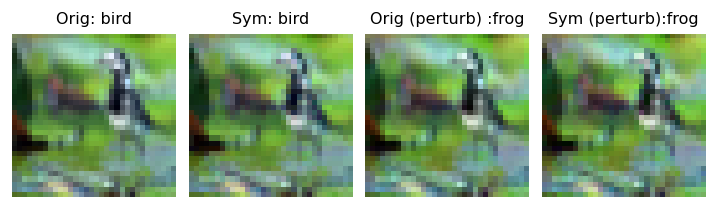

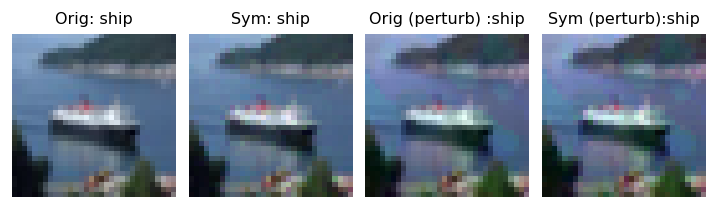

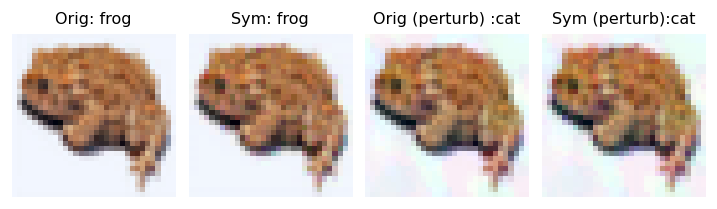

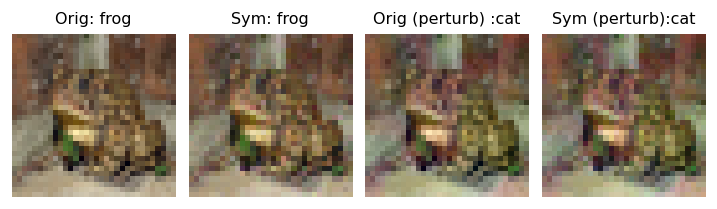

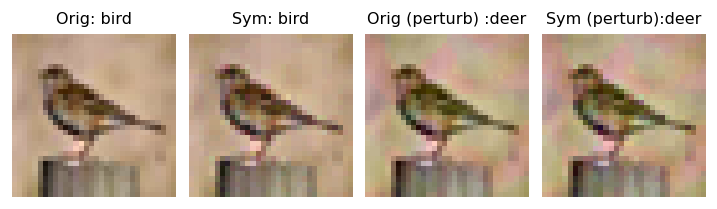

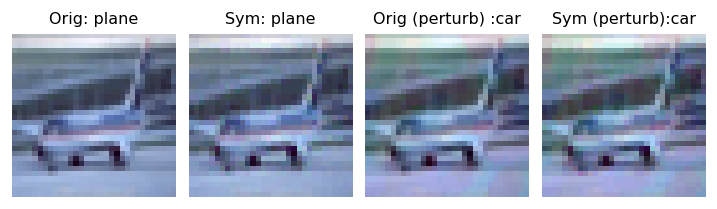

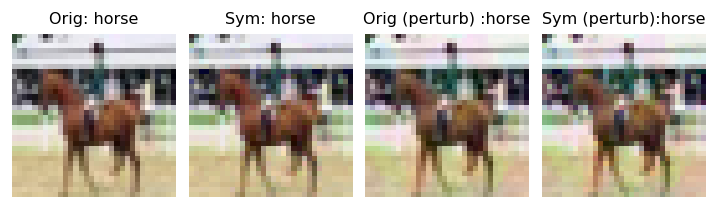

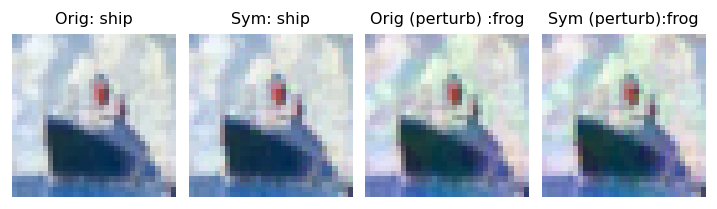

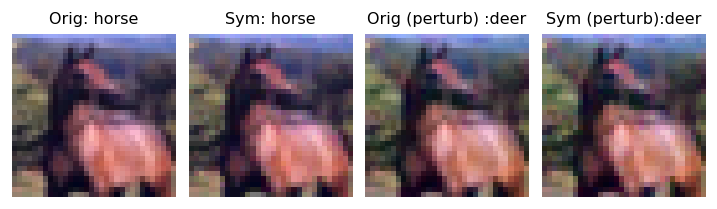

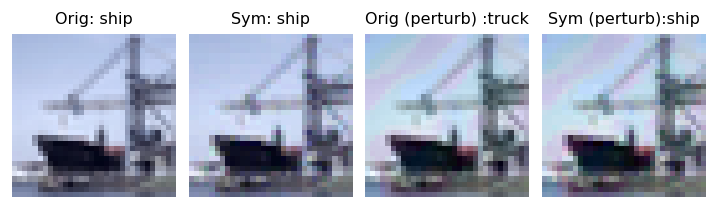

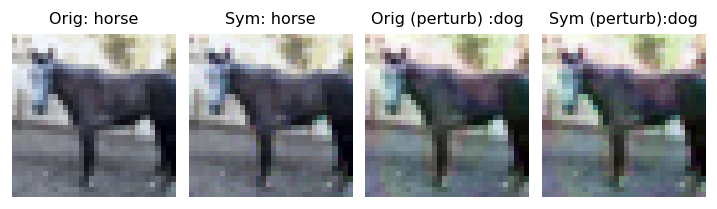

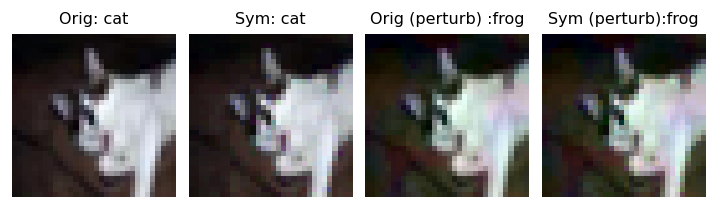

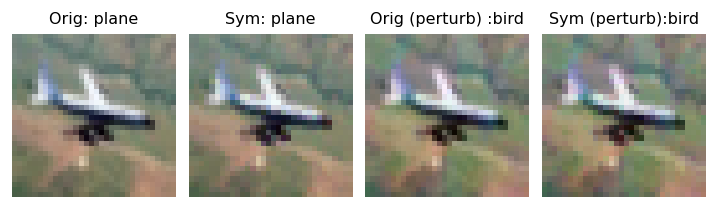

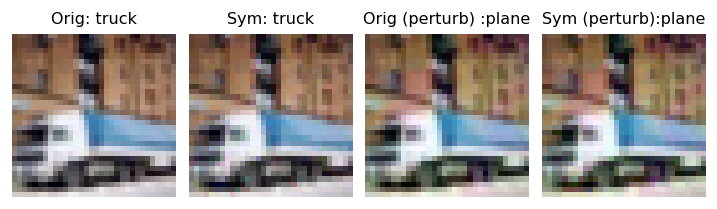

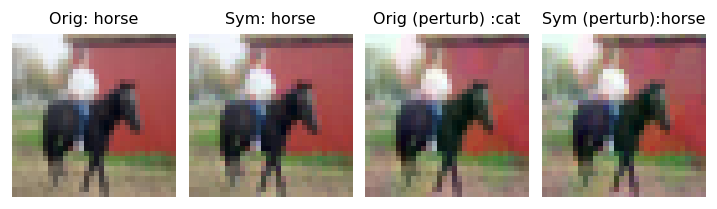

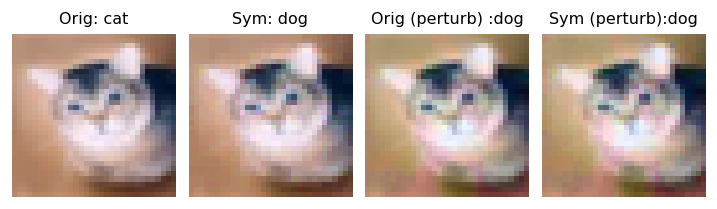

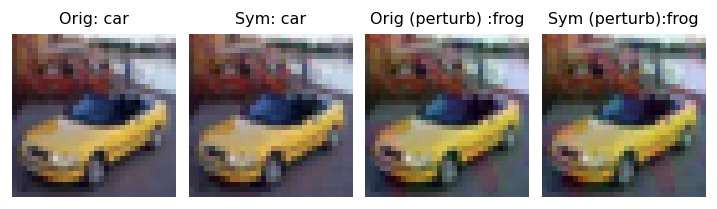

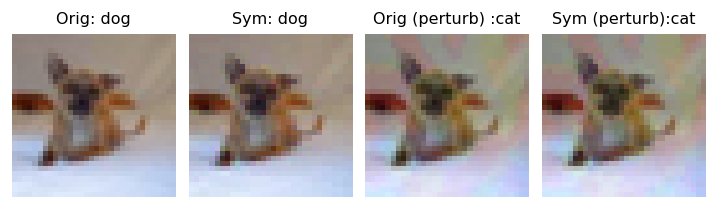

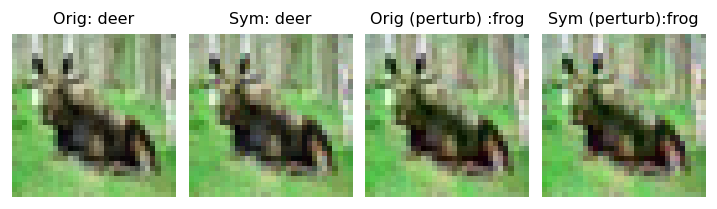

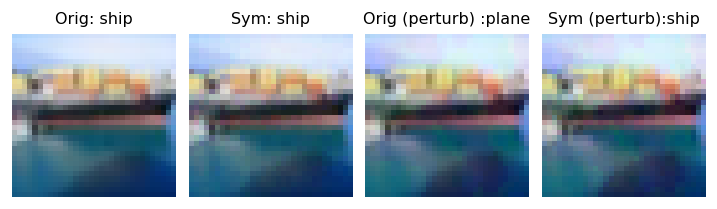

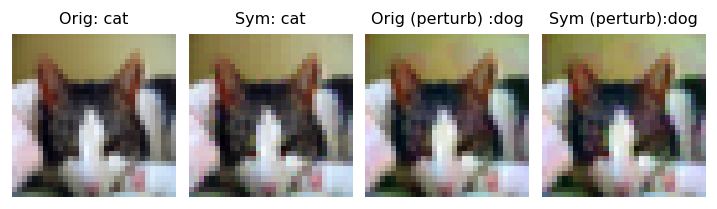

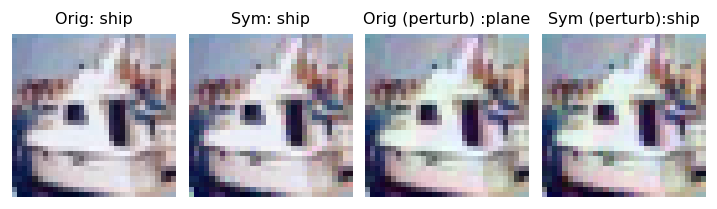

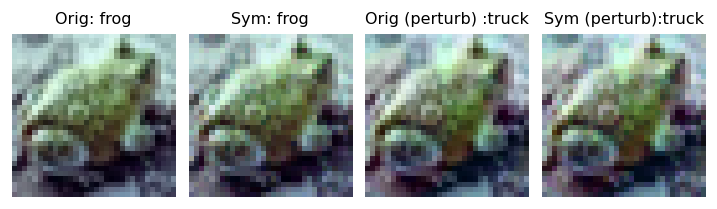

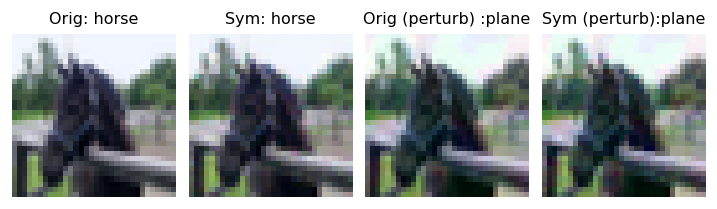

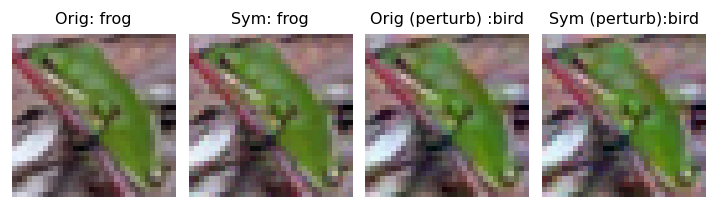

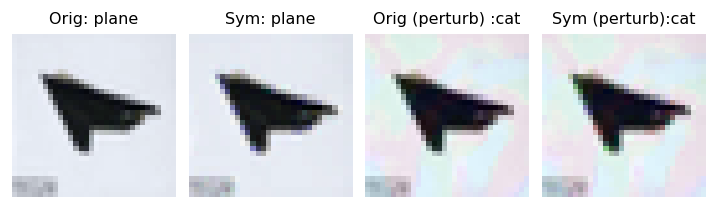

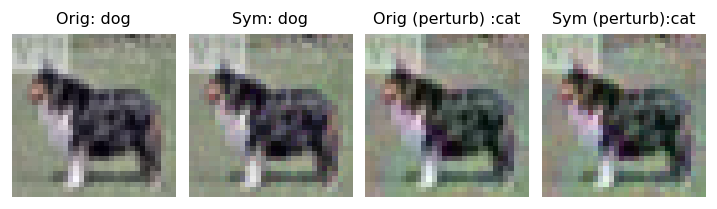

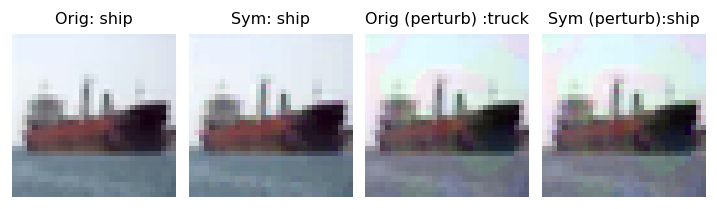

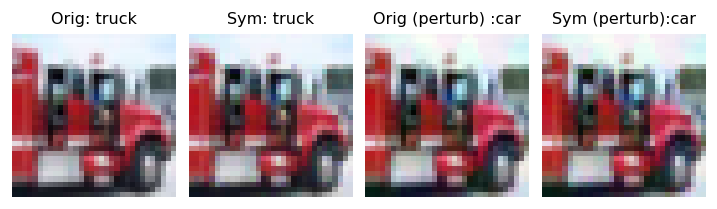

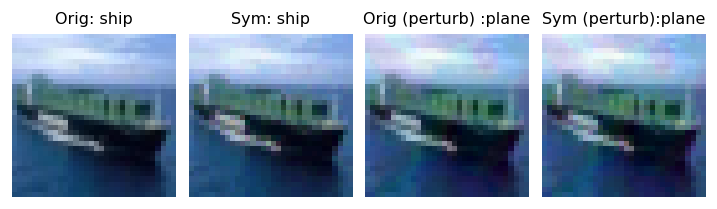

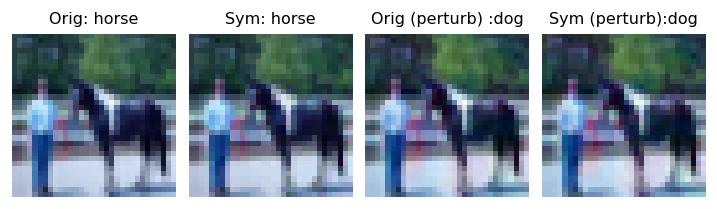

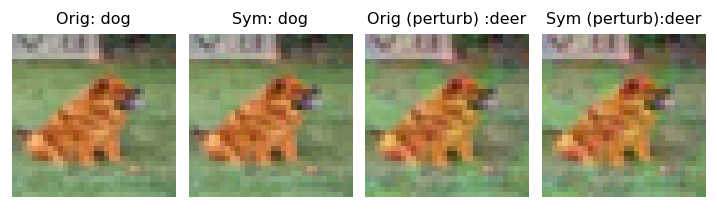

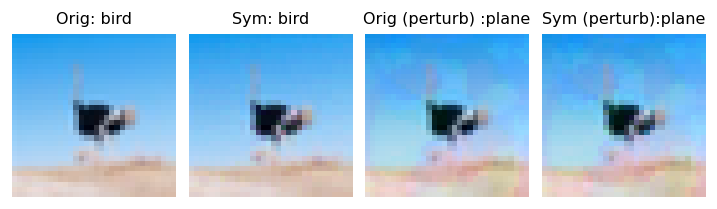

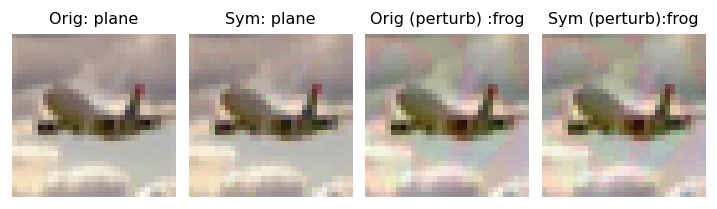

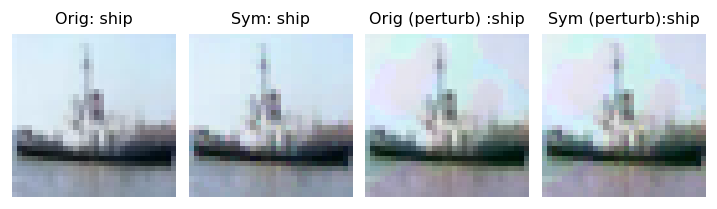

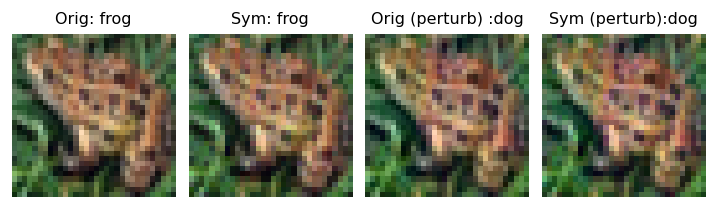

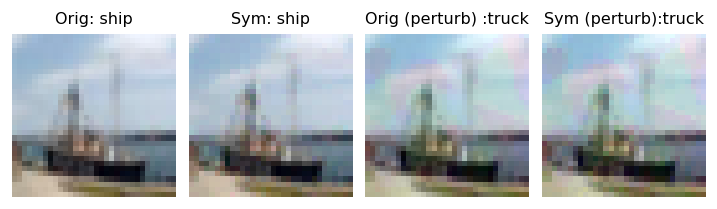

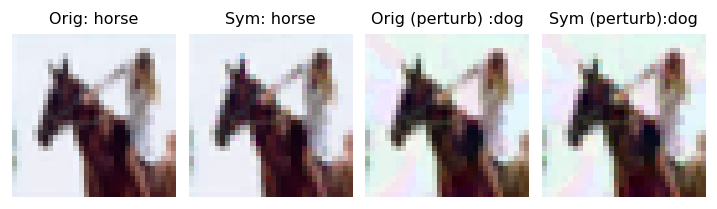

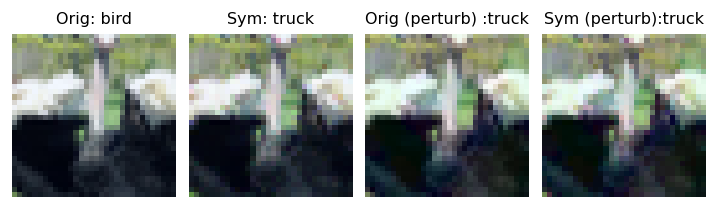

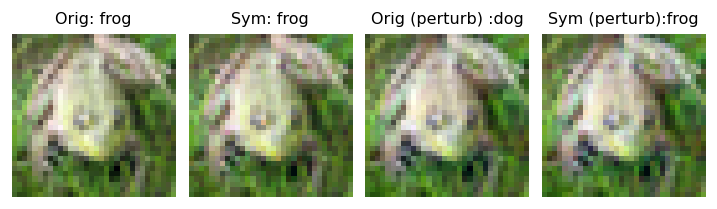

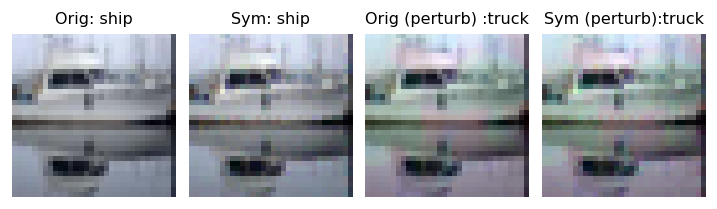

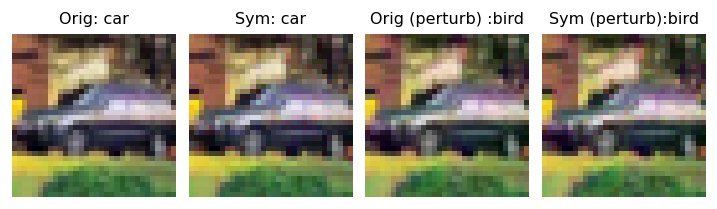

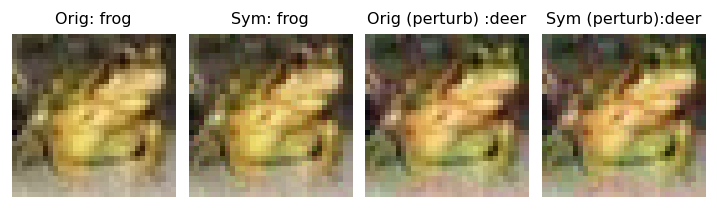

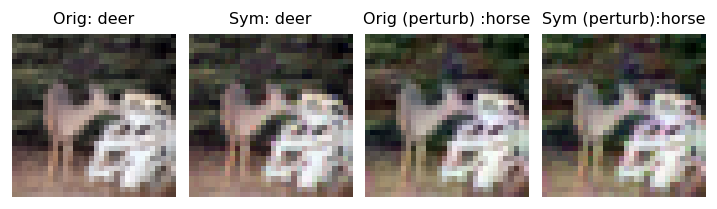

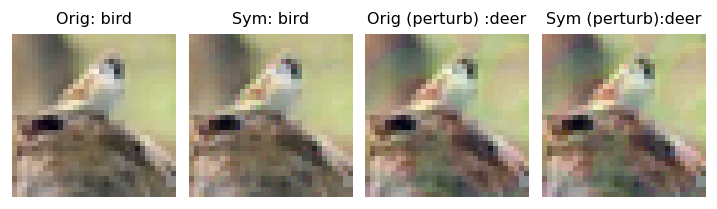

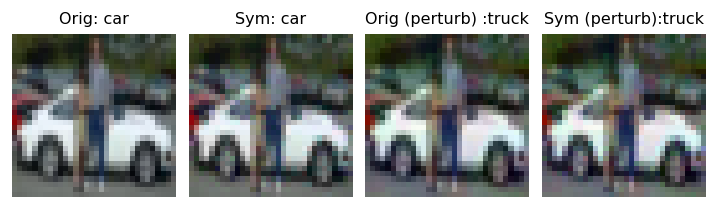

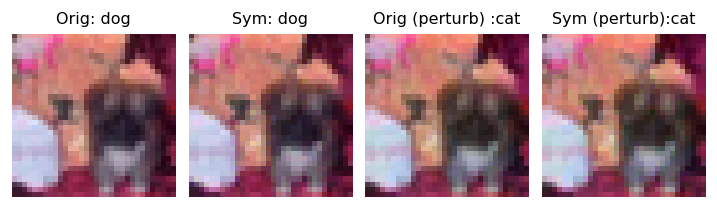

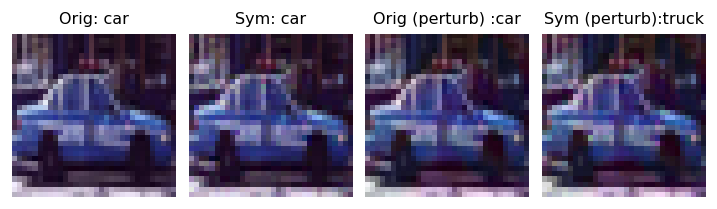

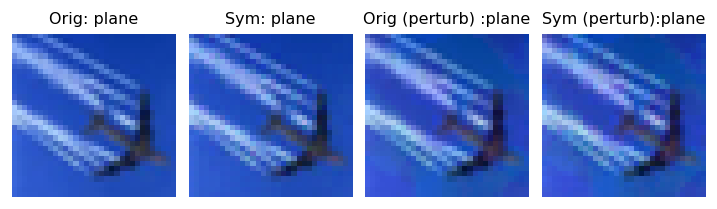

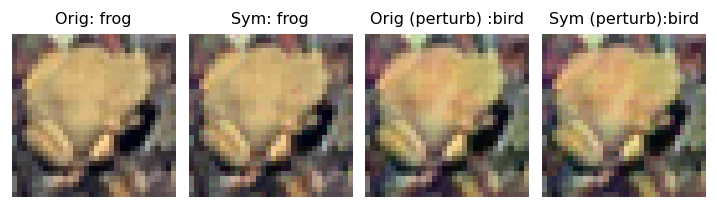

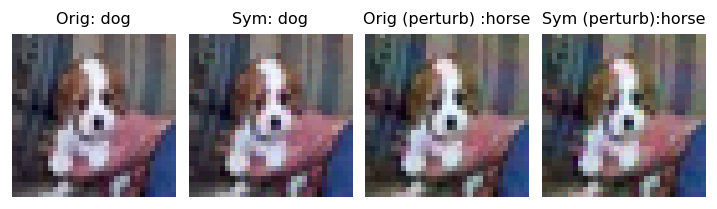

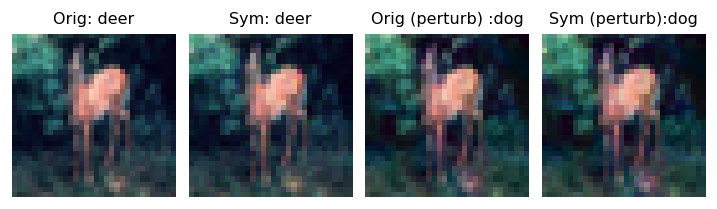

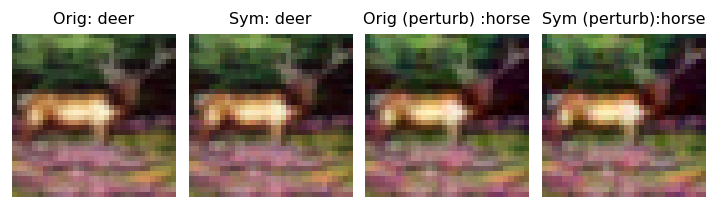

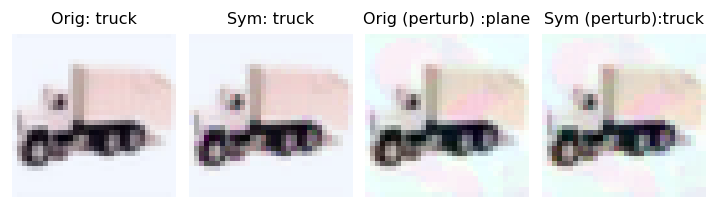

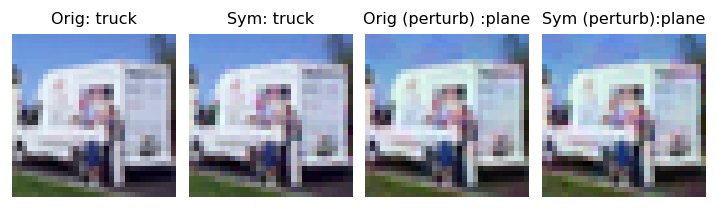

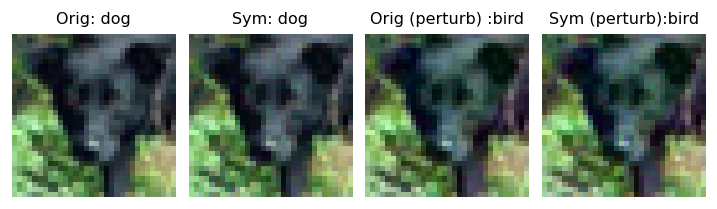

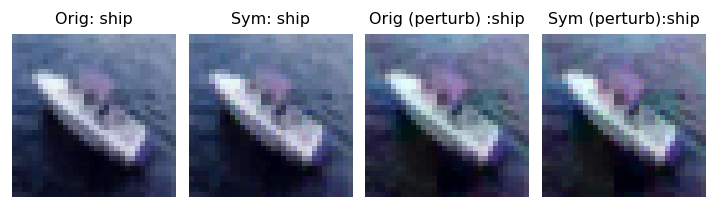

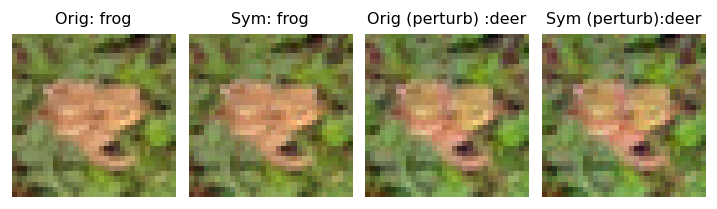

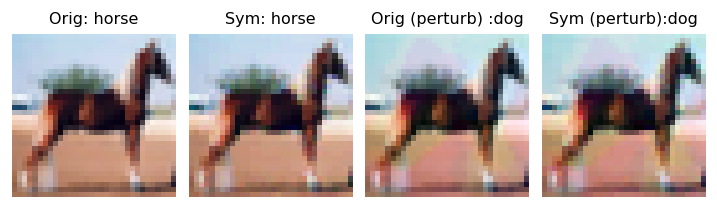

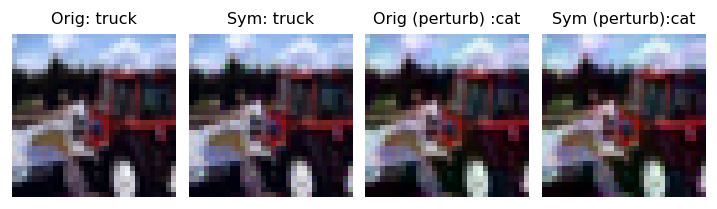

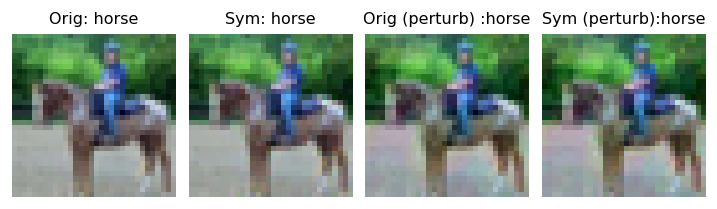

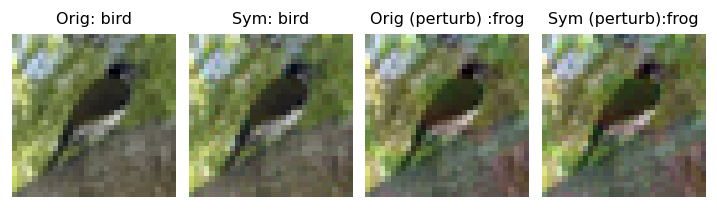

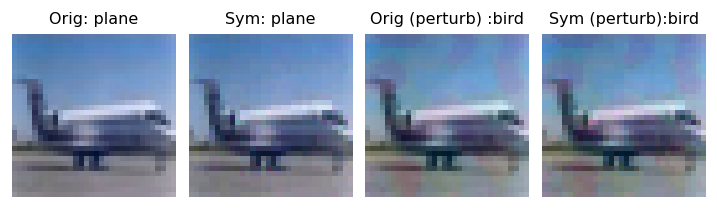

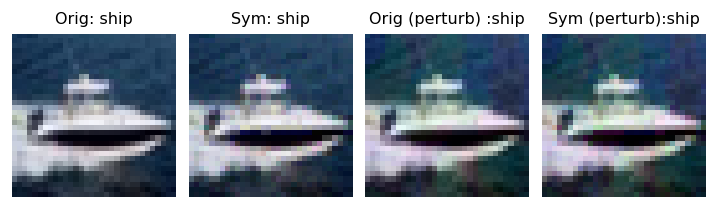

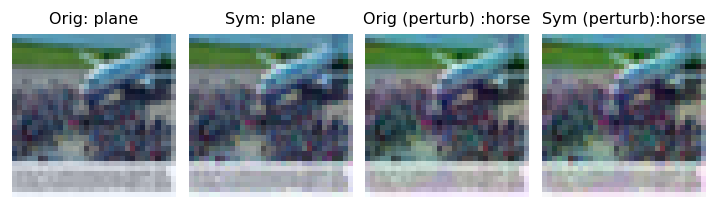

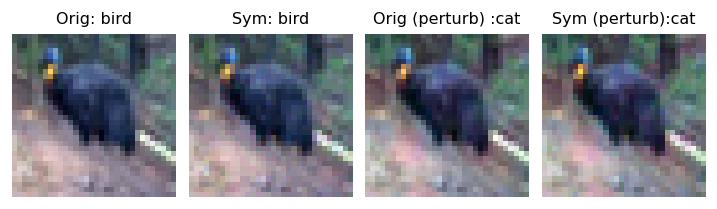

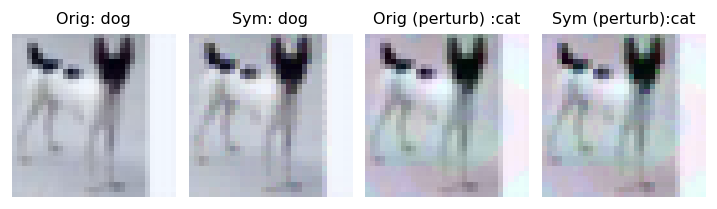

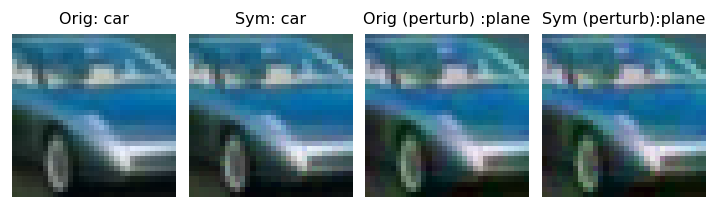

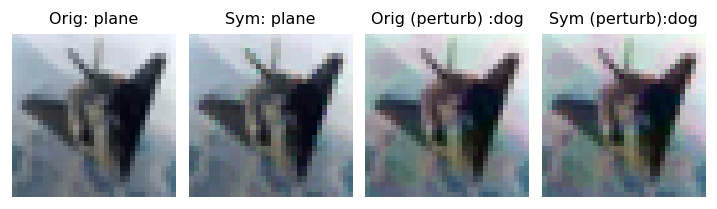

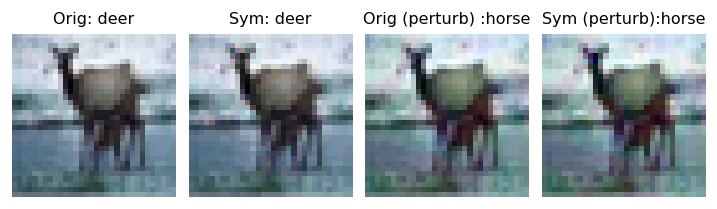

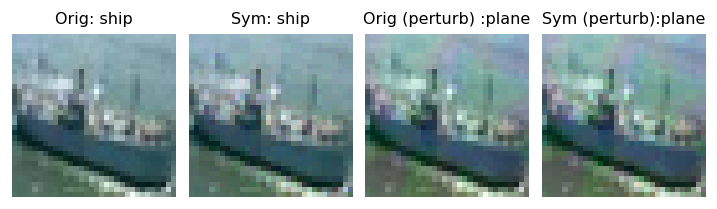

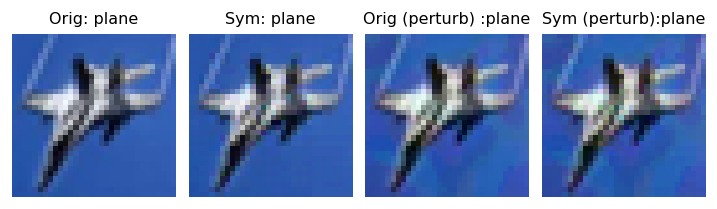

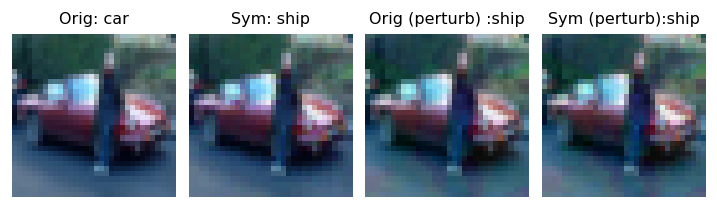

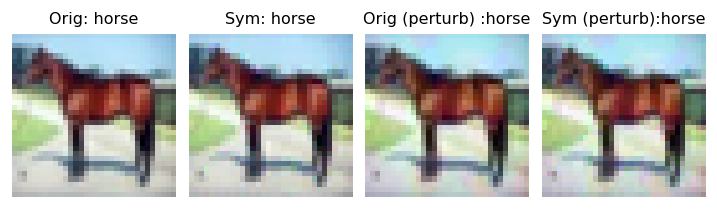

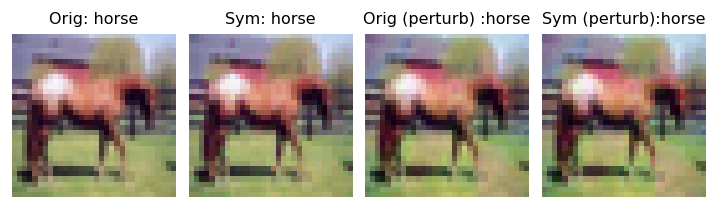

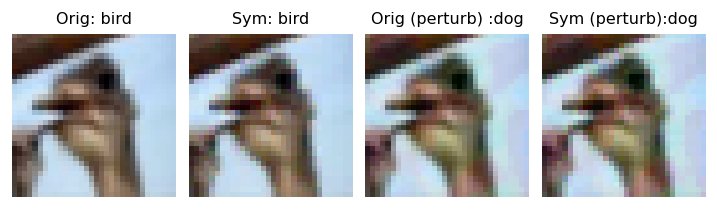

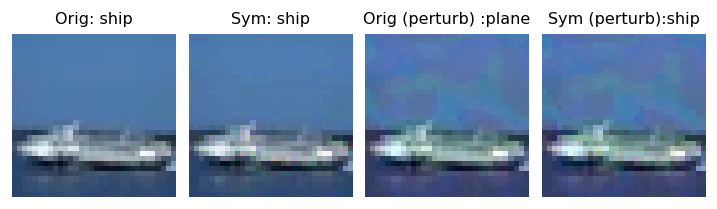

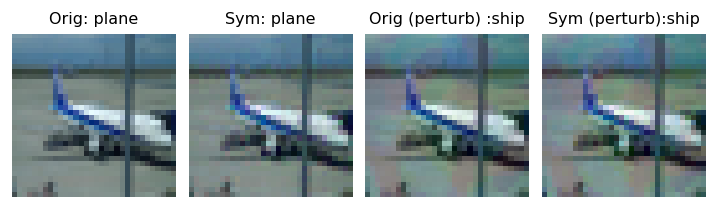

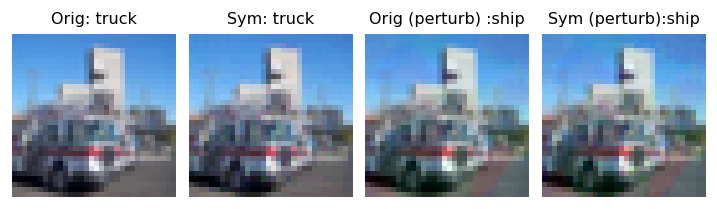

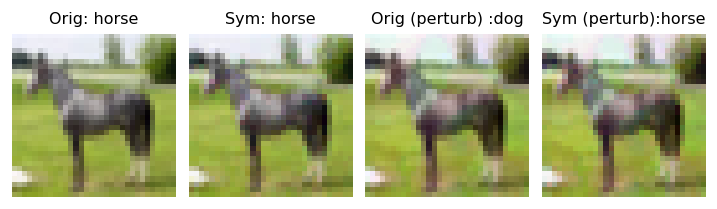

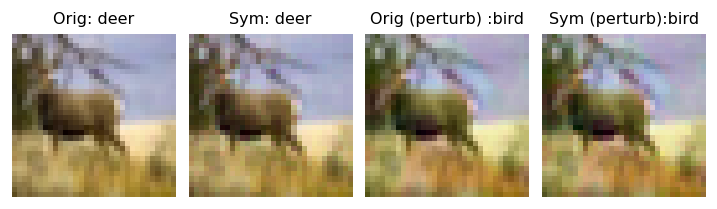

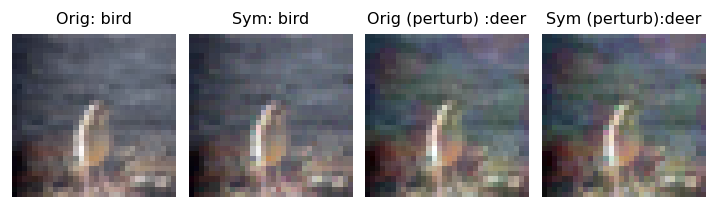

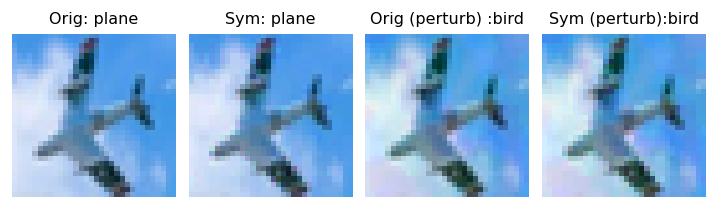

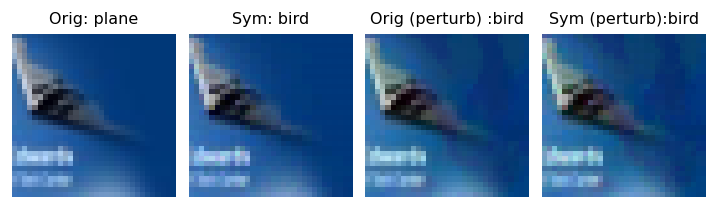

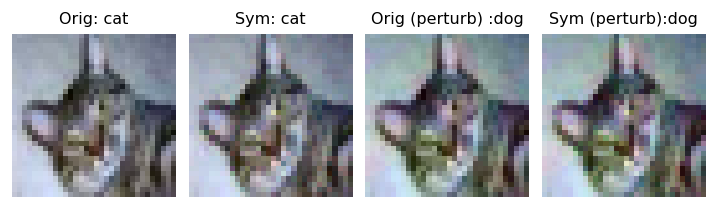

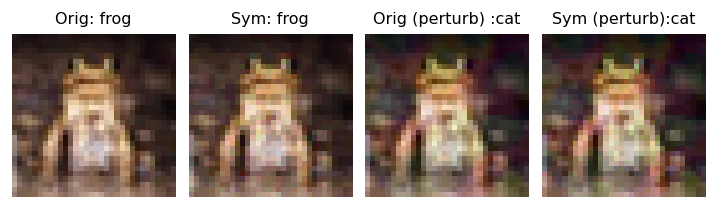

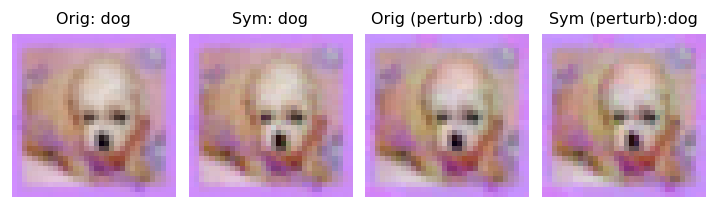

Attack on model: TIFGSM(model_name=ResNet, device=cpu, eps=0.03137254901960784, steps=100, decay=0.0, alpha=0.00784313725490196, resize_rate=0.9, diversity_prob=0.5, random_start=False, kernel_name=gaussian, len_kernel=15, nsig=3, stacked_kernel=tensor([[[[3.6163e-06, 1.1933e-05, 3.2770e-05, 7.4892e-05, 1.4244e-04,
           2.2545e-04, 2.9696e-04, 3.2552e-04, 2.9696e-04, 2.2545e-04,
           1.4244e-04, 7.4892e-05, 3.2770e-05, 1.1933e-05, 3.6163e-06],
          [1.1933e-05, 3.9377e-05, 1.0814e-04, 2.4713e-04, 4.7003e-04,
           7.4395e-04, 9.7993e-04, 1.0742e-03, 9.7993e-04, 7.4395e-04,
           4.7003e-04, 2.4713e-04, 1.0814e-04, 3.9377e-05, 1.1933e-05],
          [3.2770e-05, 1.0814e-04, 2.9696e-04, 6.7867e-04, 1.2908e-03,
           2.0430e-03, 2.6910e-03, 2.9499e-03, 2.6910e-03, 2.0430e-03,
           1.2908e-03, 6.7867e-04, 2.9696e-04, 1.0814e-04, 3.2770e-05],
          [7.4892e-05, 2.4713e-04, 6.7867e-04, 1.5510e-03, 2.9499e-03,
           4.6690e-03, 6.1500e-03, 6.7416

In [16]:
viz_adversarial_attack(TIFGSM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5), model_base_clamped_gradinit, 2000,  True,  norm=False)

In [48]:
viz_adversarial_attack(TIFGSM(model_base_clamped_gradinit, eps=8/255, alpha=2/255, steps=100, diversity_prob=0.5,norm='L2'), model_base_clamped_gradinit, 2000,  True,  norm=False)

TypeError: __init__() got an unexpected keyword argument 'norm'

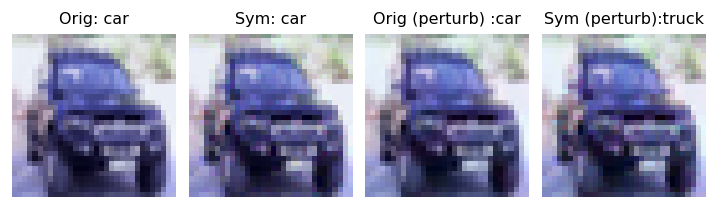

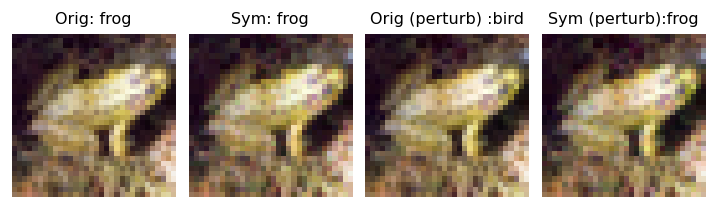

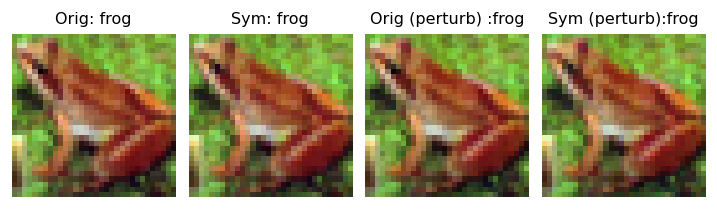

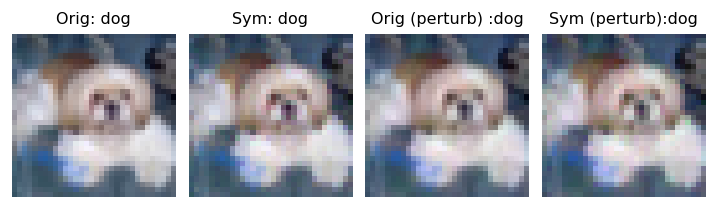

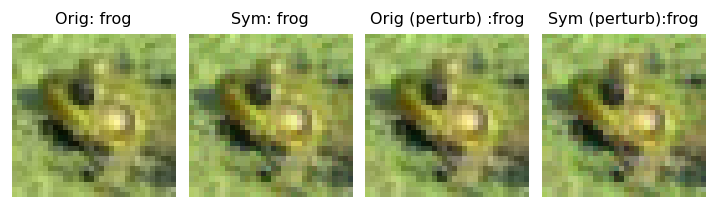

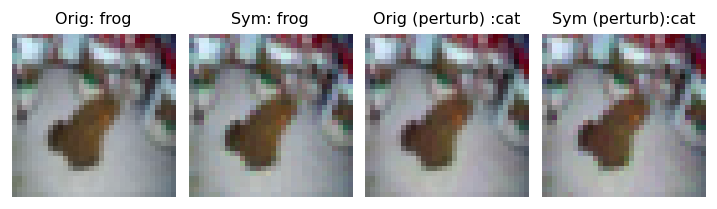

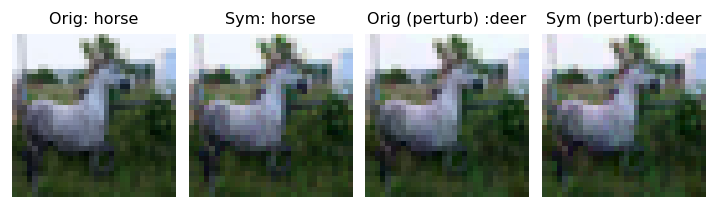

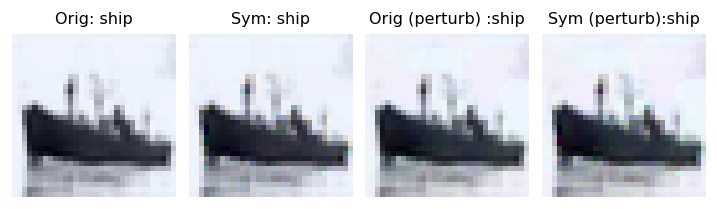

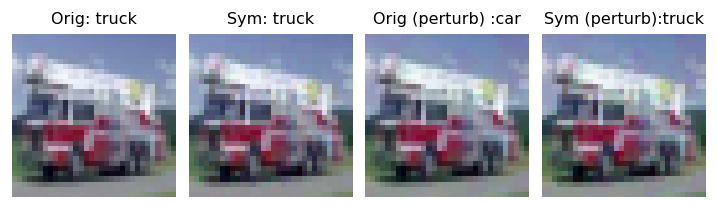

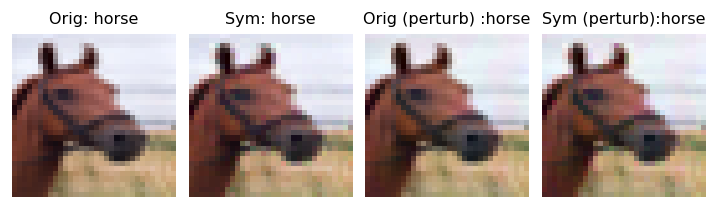

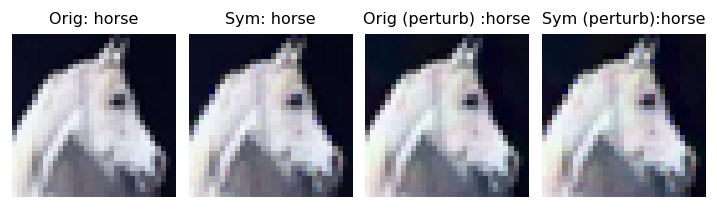

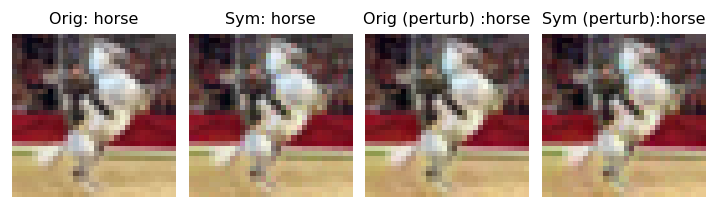

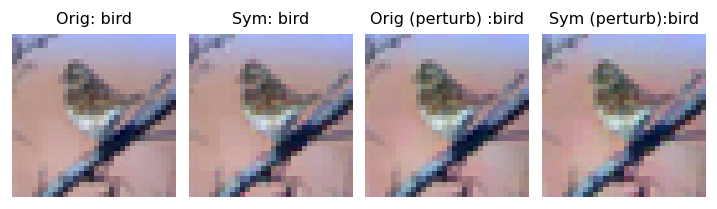

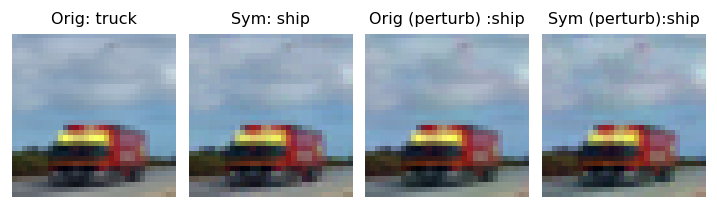

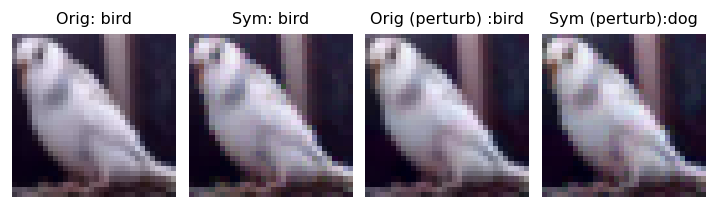

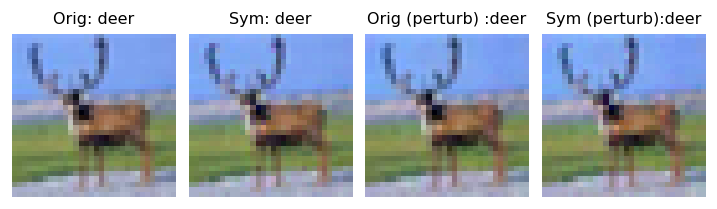

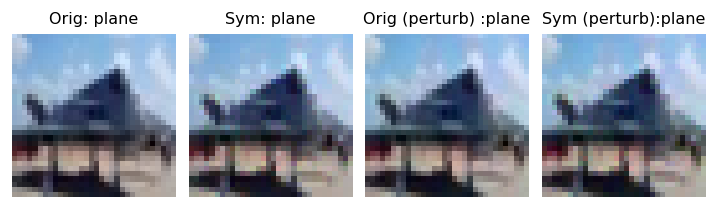

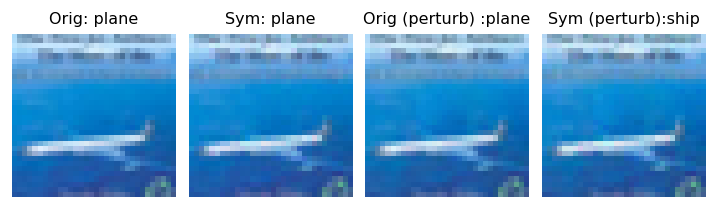

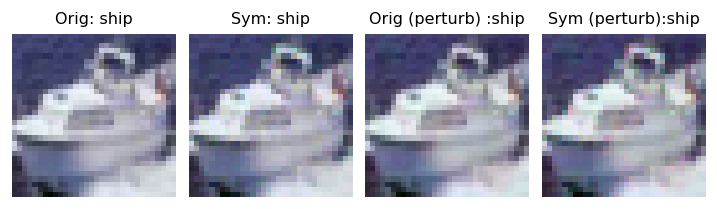

Attack on model: TIFGSM(model_name=ResNet, device=cpu, eps=0.01568627450980392, steps=100, decay=0.0, alpha=0.00784313725490196, resize_rate=0.9, diversity_prob=0.5, random_start=False, kernel_name=gaussian, len_kernel=15, nsig=3, stacked_kernel=tensor([[[[3.6163e-06, 1.1933e-05, 3.2770e-05, 7.4892e-05, 1.4244e-04,
           2.2545e-04, 2.9696e-04, 3.2552e-04, 2.9696e-04, 2.2545e-04,
           1.4244e-04, 7.4892e-05, 3.2770e-05, 1.1933e-05, 3.6163e-06],
          [1.1933e-05, 3.9377e-05, 1.0814e-04, 2.4713e-04, 4.7003e-04,
           7.4395e-04, 9.7993e-04, 1.0742e-03, 9.7993e-04, 7.4395e-04,
           4.7003e-04, 2.4713e-04, 1.0814e-04, 3.9377e-05, 1.1933e-05],
          [3.2770e-05, 1.0814e-04, 2.9696e-04, 6.7867e-04, 1.2908e-03,
           2.0430e-03, 2.6910e-03, 2.9499e-03, 2.6910e-03, 2.0430e-03,
           1.2908e-03, 6.7867e-04, 2.9696e-04, 1.0814e-04, 3.2770e-05],
          [7.4892e-05, 2.4713e-04, 6.7867e-04, 1.5510e-03, 2.9499e-03,
           4.6690e-03, 6.1500e-03, 6.7416

In [18]:
viz_adversarial_attack(TIFGSM(model_base_clamped_gradinit, eps=4/255, alpha=2/255, steps=100, diversity_prob=0.5), model_base_clamped_gradinit, 200,  True,  norm=False)

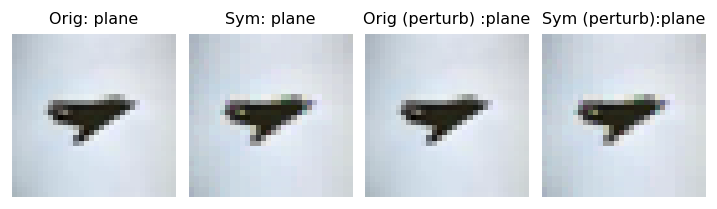

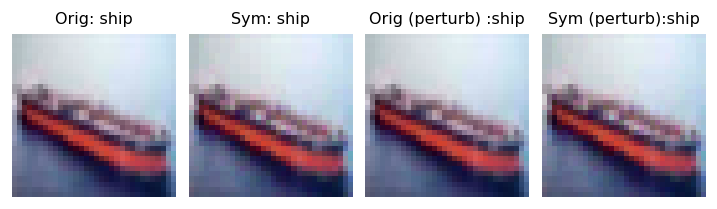

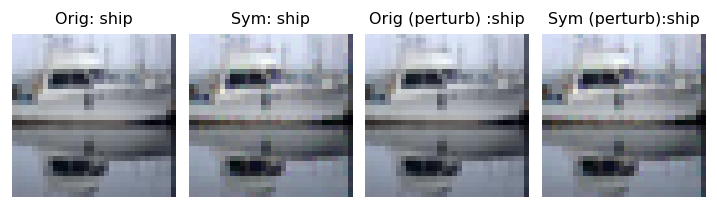

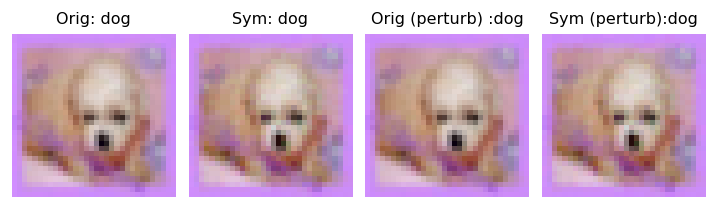

Attack on model: APGDT(model_name=ResNet, device=cpu, eps=0.03137254901960784, steps=100, norm=L2, n_restarts=1, seed=0, eot_iter=1, thr_decr=0.75, verbose=False, target_class=10, n_target_classes=9, steps_2=22, steps_min=6, size_decr=3, attack_mode=default, return_type=float)
Standard accuracy: 91.35 %
Symbolic accuracy: 87.96 %
Attacked standard accuracy: 77.71 %
Attacked Symbolic accuracy: 86.31 %


In [46]:
viz_adversarial_attack(APGDT(model_base_clamped_gradinit, eps=8/255, steps=100, eot_iter=1, n_restarts=1, norm='L2'), model_base_clamped_gradinit, 2000,  True,  norm=False)

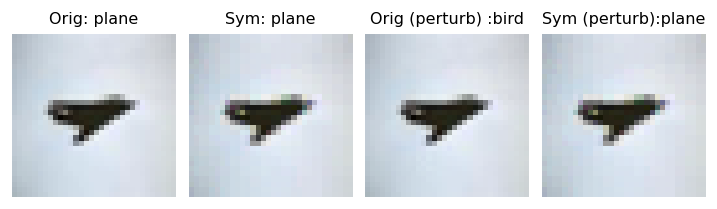

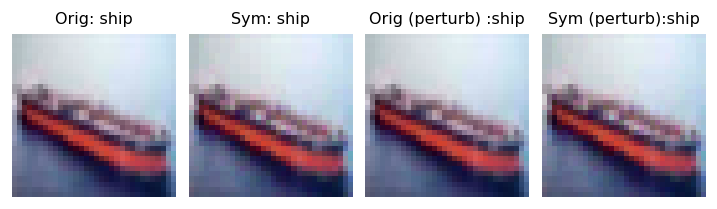

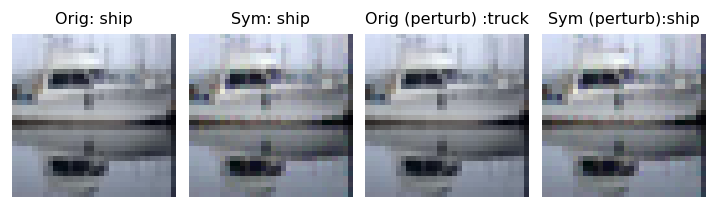

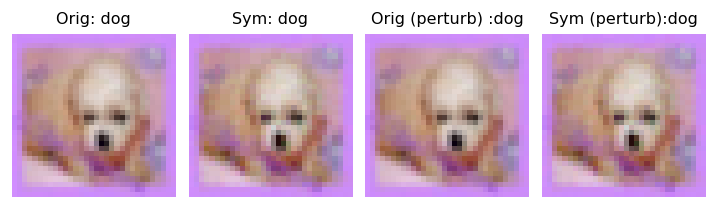

Attack on model: APGDT(model_name=ResNet, device=cpu, eps=0.06274509803921569, steps=100, norm=L2, n_restarts=1, seed=0, eot_iter=1, thr_decr=0.75, verbose=False, target_class=10, n_target_classes=9, steps_2=22, steps_min=6, size_decr=3, attack_mode=default, return_type=float)
Standard accuracy: 91.35 %
Symbolic accuracy: 87.96 %
Attacked standard accuracy: 56.82 %
Attacked Symbolic accuracy: 83.16 %


In [48]:
viz_adversarial_attack(APGDT(model_base_clamped_gradinit, eps=16/255, steps=100, eot_iter=1, n_restarts=1, norm='L2'), model_base_clamped_gradinit, 2000,  True,  norm=False)

In [17]:
viz_adversarial_attack(Jitter(model_base_clamped_gradinit, eps=2/255, alpha=2/255, steps=40, scale=10, std=0.1, random_start=True), model_base_clamped_gradinit, 20,  True,  norm=False)

Attack on model: Jitter(model_name=ResNet, device=cpu, eps=0.00784313725490196, alpha=0.00784313725490196, steps=40, random_start=True, scale=10, std=0.1, attack_mode=default, return_type=float)
Standard accuracy: 95.24 %
Symbolic accuracy: 85.71 %
Attacked standard accuracy: 4.76 %
Attacked Symbolic accuracy: 52.38 %
